# Packages

In [1]:
import warnings
warnings.filterwarnings("ignore")
import os

import pandas as pd
import numpy as np
import polars as pl
import scipy.stats as stats
import seaborn as sns
import statsmodels.formula.api as smf
import statsmodels.api as sm
import matplotlib.pyplot as plt
import math

from statsmodels.tsa.deterministic import DeterministicProcess, CalendarFourier
from statsmodels.graphics.tsaplots import plot_pacf

from sklearn.model_selection import GroupKFold, KFold, train_test_split, cross_val_score, TimeSeriesSplit
from sklearn.preprocessing import RobustScaler, LabelEncoder
from sklearn.metrics import mean_squared_error, r2_score, make_scorer, accuracy_score, median_absolute_error, classification_report, mean_absolute_error, roc_auc_score, roc_curve
from sklearn.pipeline import make_pipeline
from sklearn.decomposition import PCA
from imblearn.over_sampling import RandomOverSampler
from scipy.optimize import minimize

import xgboost as xgb
import lightgbm as lgb
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, StackingRegressor, RandomForestClassifier
from sklearn.linear_model import Ridge
from sklearn.svm import LinearSVC
from sklearn.svm import SVR
from sklearn.linear_model import LogisticRegression

import optuna

pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 500)
pd.set_option('display.float_format', lambda x: "%.4f" % x)
# pd.options.plotting.backend = "plotly"

plt.style.use('ggplot')
sns.set_style('darkgrid')

## Helper Functions

In [2]:
def get_info(df):
    missing_values_train = pd.DataFrame({'Feature': df.columns,
                              'No. of Missing Values': df.isnull().sum().values,
                              '% of Missing Values': ((df.isnull().sum().values)/len(df)*100)})

    unique_values = pd.DataFrame({'Feature': df.columns,
                                'No. of Unique Values': df.nunique().values})

    feature_types = pd.DataFrame({'Feature': df.columns,
                                'DataType': df.dtypes})

    merged_df = pd.merge(missing_values_train, unique_values, on='Feature', how='left')
    merged_df = pd.merge(merged_df, feature_types, on='Feature', how='left')

    return merged_df

def get_cols_as_list_by_type(df, target_col=None):
    if target_col is not None:
        df = df.drop(target_col, axis=1)
        
    numeric_cols = df.select_dtypes(include=['number']).columns.tolist()
    categorical_cols = df.select_dtypes(include=['object', 'category']).columns.tolist()
    return numeric_cols, categorical_cols

# plot all pairs in rows of 6 
def pairplot_list_against_list(df, l1, l2):
    pairs = [(x, y) for x in l1 for y in l2]
    num_plots = len(pairs)
    cols = 6
    rows = math.ceil(num_plots / cols)

    fig, axes = plt.subplots(rows, cols, figsize=(cols * 3, rows * 3))
    axes = axes.flatten()

    for i, (x, y) in enumerate(pairs):
        sns.scatterplot(data=df, x=x, y=y, ax=axes[i])
        axes[i].set_xlabel(x)
        axes[i].set_ylabel(y)

    # Hide any unused subplots
    for j in range(i + 1, len(axes)):
        axes[j].axis('off')

    plt.tight_layout()
    plt.show()

# Reading Data

In [3]:
dir_name2022 = "/Users/kylewang/Documents/yale/SDS4250_StatCaseStudies/OlympicFigureSkating/2022oly_score_sheets"
data_path2022 = dir_name2022 + "/oly2022_singles.csv"
data_df2022 = pd.read_csv(data_path2022)
data_df2022["year"] = 2022

dir_name2018 = "/Users/kylewang/Documents/yale/SDS4250_StatCaseStudies/OlympicFigureSkating/2018oly_score_sheets"
data_path2018 = dir_name2018 + "/oly2018_singles.csv"
data_df2018 = pd.read_csv(data_path2018)
data_df2018["year"] = 2018

data_df = pd.concat([data_df2018, data_df2022])
data_df.sort_values(by=["year", "is_short_program", "is_mens", "rank"], inplace=True)
data_df.head()

rank               name  noc  starting_number      tss     tes    tpcs  \
0     1  Medvedeva Evgenia  OAR               24 156.6500 79.1800 77.4700   
1     1  Medvedeva Evgenia  OAR               24 156.6500 79.1800 77.4700   
2     1  Medvedeva Evgenia  OAR               24 156.6500 79.1800 77.4700   
3     1  Medvedeva Evgenia  OAR               24 156.6500 79.1800 77.4700   
4     1  Medvedeva Evgenia  OAR               24 156.6500 79.1800 77.4700   

   deductions  base_value  element  element_no  extra_points  factor  \
0      0.0000      9.6000    3F+3T      1.0000        0.0000     NaN   
1      0.0000      6.0000      3Lz      2.0000        0.0000     NaN   
2      0.0000      3.5000  FCCoSp4      3.0000        0.0000     NaN   
3      0.0000      3.9000    StSq4      4.0000        0.0000     NaN   
4      0.0000      5.8300       3F      5.0000        1.0000     NaN   

   final_score    goe info program_component     J1     J2     J3     J4  \
0      11.0000 1.4000  NaN               NaN 2.0000 2.0000 3.0000 2.0000   
1       7.6000 1.6000  NaN               NaN 2.0000 3.0000 3.0000 2.0000   
2       4.5700 1.0700  NaN               NaN 2.0000 2.0000 3.0000 3.0000   
3       5.9000 2.0000  NaN               NaN 2.0000 3.0000 3.0000 3.0000   
4       7.7300 1.9000  NaN               NaN 3.0000 3.0000 3.0000 3.0000   

      J5     J6     J7     J8     J9  is_short_program  is_mens  year  
0 2.0000 2.0000 2.0000 2.0000 2.0000                 0        0  2018  
1 2.0000 2.0000 2.0000 2.0000 3.0000                 0        0  2018  
2 1.0000 2.0000 2.0000 2.0000 2.0000                 0        0  2018  
3 2.0000 3.0000 3.0000 3.0000 3.0000                 0        0  2018  
4 3.0000 2.0000 2.0000 2.0000 3.0000                 0        0  2018

In [4]:
judge_path = "/Users/kylewang/Documents/yale/SDS4250_StatCaseStudies/OlympicFigureSkating/judge_nationalities.csv"
judge_df = pd.read_csv(judge_path)
judge_df = (
    judge_df
        .pivot(
            index=['year', 'is_short_program', 'is_mens'], 
            columns='judge_number', 
            values='judge_nationality'
            )
        .set_axis([f'judge{int(i)}_nat' for i in range(1, 10)], axis=1)
        .reset_index()
)
judge_df


year  is_short_program  is_mens judge1_nat judge2_nat judge3_nat  \
0  2018                 0        0        CAN        LAT        KOR   
1  2018                 0        1        KAZ        USA        UZB   
2  2018                 1        0        SVK        HUN        USA   
3  2018                 1        1        ESP        LAT        FRA   
4  2022                 0        0        ROC        NED        JPN   
5  2022                 0        1        CHN        BLR        JPN   
6  2022                 1        0        GBR        NED        CHN   
7  2022                 1        1        ITA        CHN        ISR   

  judge4_nat judge5_nat judge6_nat judge7_nat judge8_nat judge9_nat  
0        ROC        CHN        FRA        BEL        USA        GER  
1        JPN        ISR        ROC        CHN        CZE        LAT  
2        JPN        KOR        CHN        ROC        KAZ        LAT  
3        UZB        JPN        ROC        USA        CAN        CHN  
4        CHN        USA        GBR        AUT        EST        CAN  
5        MEX        CZE        ISR        SWE        EST        CAN  
6        AUT        CAN        USA        CZE        EST        KOR  
7        JPN        FRA        KOR        BLR        SWE        CAN

In [5]:
data_df = data_df.merge(judge_df, on=['year', 'is_short_program', 'is_mens'], how='left')
data_df.head()

rank               name  noc  starting_number      tss     tes    tpcs  \
0     1  Medvedeva Evgenia  OAR               24 156.6500 79.1800 77.4700   
1     1  Medvedeva Evgenia  OAR               24 156.6500 79.1800 77.4700   
2     1  Medvedeva Evgenia  OAR               24 156.6500 79.1800 77.4700   
3     1  Medvedeva Evgenia  OAR               24 156.6500 79.1800 77.4700   
4     1  Medvedeva Evgenia  OAR               24 156.6500 79.1800 77.4700   

   deductions  base_value  element  element_no  extra_points  factor  \
0      0.0000      9.6000    3F+3T      1.0000        0.0000     NaN   
1      0.0000      6.0000      3Lz      2.0000        0.0000     NaN   
2      0.0000      3.5000  FCCoSp4      3.0000        0.0000     NaN   
3      0.0000      3.9000    StSq4      4.0000        0.0000     NaN   
4      0.0000      5.8300       3F      5.0000        1.0000     NaN   

   final_score    goe info program_component     J1     J2     J3     J4  \
0      11.0000 1.4000  NaN               NaN 2.0000 2.0000 3.0000 2.0000   
1       7.6000 1.6000  NaN               NaN 2.0000 3.0000 3.0000 2.0000   
2       4.5700 1.0700  NaN               NaN 2.0000 2.0000 3.0000 3.0000   
3       5.9000 2.0000  NaN               NaN 2.0000 3.0000 3.0000 3.0000   
4       7.7300 1.9000  NaN               NaN 3.0000 3.0000 3.0000 3.0000   

      J5     J6     J7     J8     J9  is_short_program  is_mens  year  \
0 2.0000 2.0000 2.0000 2.0000 2.0000                 0        0  2018   
1 2.0000 2.0000 2.0000 2.0000 3.0000                 0        0  2018   
2 1.0000 2.0000 2.0000 2.0000 2.0000                 0        0  2018   
3 2.0000 3.0000 3.0000 3.0000 3.0000                 0        0  2018   
4 3.0000 2.0000 2.0000 2.0000 3.0000                 0        0  2018   

  judge1_nat judge2_nat judge3_nat judge4_nat judge5_nat judge6_nat  \
0        CAN        LAT        KOR        ROC        CHN        FRA   
1        CAN        LAT        KOR        ROC        CHN        FRA   
2        CAN        LAT        KOR        ROC        CHN        FRA   
3        CAN        LAT        KOR        ROC        CHN        FRA   
4        CAN        LAT        KOR        ROC        CHN        FRA   

  judge7_nat judge8_nat judge9_nat  
0        BEL        USA        GER  
1        BEL        USA        GER  
2        BEL        USA        GER  
3        BEL        USA        GER  
4        BEL        USA        GER

In [6]:
# adding is same nationality for each judge
data_df = (
    data_df.assign(
        judge1_same = lambda x: (x.judge1_nat == x.noc).astype(int),
        judge2_same = lambda x: (x.judge2_nat == x.noc).astype(int),
        judge3_same = lambda x: (x.judge3_nat == x.noc).astype(int),
        judge4_same = lambda x: (x.judge4_nat == x.noc).astype(int),
        judge5_same = lambda x: (x.judge5_nat == x.noc).astype(int),
        judge6_same = lambda x: (x.judge6_nat == x.noc).astype(int),
        judge7_same = lambda x: (x.judge7_nat == x.noc).astype(int),
        judge8_same = lambda x: (x.judge8_nat == x.noc).astype(int),
        judge9_same = lambda x: (x.judge9_nat == x.noc).astype(int),
    )
)
data_df.head()

rank               name  noc  starting_number      tss     tes    tpcs  \
0     1  Medvedeva Evgenia  OAR               24 156.6500 79.1800 77.4700   
1     1  Medvedeva Evgenia  OAR               24 156.6500 79.1800 77.4700   
2     1  Medvedeva Evgenia  OAR               24 156.6500 79.1800 77.4700   
3     1  Medvedeva Evgenia  OAR               24 156.6500 79.1800 77.4700   
4     1  Medvedeva Evgenia  OAR               24 156.6500 79.1800 77.4700   

   deductions  base_value  element  element_no  extra_points  factor  \
0      0.0000      9.6000    3F+3T      1.0000        0.0000     NaN   
1      0.0000      6.0000      3Lz      2.0000        0.0000     NaN   
2      0.0000      3.5000  FCCoSp4      3.0000        0.0000     NaN   
3      0.0000      3.9000    StSq4      4.0000        0.0000     NaN   
4      0.0000      5.8300       3F      5.0000        1.0000     NaN   

   final_score    goe info program_component     J1     J2     J3     J4  \
0      11.0000 1.4000  NaN               NaN 2.0000 2.0000 3.0000 2.0000   
1       7.6000 1.6000  NaN               NaN 2.0000 3.0000 3.0000 2.0000   
2       4.5700 1.0700  NaN               NaN 2.0000 2.0000 3.0000 3.0000   
3       5.9000 2.0000  NaN               NaN 2.0000 3.0000 3.0000 3.0000   
4       7.7300 1.9000  NaN               NaN 3.0000 3.0000 3.0000 3.0000   

      J5     J6     J7     J8     J9  is_short_program  is_mens  year  \
0 2.0000 2.0000 2.0000 2.0000 2.0000                 0        0  2018   
1 2.0000 2.0000 2.0000 2.0000 3.0000                 0        0  2018   
2 1.0000 2.0000 2.0000 2.0000 2.0000                 0        0  2018   
3 2.0000 3.0000 3.0000 3.0000 3.0000                 0        0  2018   
4 3.0000 2.0000 2.0000 2.0000 3.0000                 0        0  2018   

  judge1_nat judge2_nat judge3_nat judge4_nat judge5_nat judge6_nat  \
0        CAN        LAT        KOR        ROC        CHN        FRA   
1        CAN        LAT        KOR        ROC        CHN        FRA   
2        CAN        LAT        KOR        ROC        CHN        FRA   
3        CAN        LAT        KOR        ROC        CHN        FRA   
4        CAN        LAT        KOR        ROC        CHN        FRA   

  judge7_nat judge8_nat judge9_nat  judge1_same  judge2_same  judge3_same  \
0        BEL        USA        GER            0            0            0   
1        BEL        USA        GER            0            0            0   
2        BEL        USA        GER            0            0            0   
3        BEL        USA        GER            0            0            0   
4        BEL        USA        GER            0            0            0   

   judge4_same  judge5_same  judge6_same  judge7_same  judge8_same  \
0            0            0            0            0            0   
1            0            0            0            0            0   
2            0            0            0            0            0   
3            0            0            0            0            0   
4            0            0            0            0            0   

   judge9_same  
0            0  
1            0  
2            0  
3            0  
4            0

In [56]:
data_df["element_no"].isna().any()

np.True_

In [59]:
data_df = (
    data_df
        .assign(
            is_element = lambda x: (~x.element_no.isna()).astype(int)
        )
)
data_df.head()

rank               name  noc  starting_number      tss     tes    tpcs  \
0     1  Medvedeva Evgenia  OAR               24 156.6500 79.1800 77.4700   
1     1  Medvedeva Evgenia  OAR               24 156.6500 79.1800 77.4700   
2     1  Medvedeva Evgenia  OAR               24 156.6500 79.1800 77.4700   
3     1  Medvedeva Evgenia  OAR               24 156.6500 79.1800 77.4700   
4     1  Medvedeva Evgenia  OAR               24 156.6500 79.1800 77.4700   

   deductions  base_value  element  element_no  extra_points  factor  \
0      0.0000      9.6000    3F+3T      1.0000        0.0000     NaN   
1      0.0000      6.0000      3Lz      2.0000        0.0000     NaN   
2      0.0000      3.5000  FCCoSp4      3.0000        0.0000     NaN   
3      0.0000      3.9000    StSq4      4.0000        0.0000     NaN   
4      0.0000      5.8300       3F      5.0000        1.0000     NaN   

   final_score    goe info program_component     J1     J2     J3     J4  \
0      11.0000 1.4000  NaN               NaN 2.0000 2.0000 3.0000 2.0000   
1       7.6000 1.6000  NaN               NaN 2.0000 3.0000 3.0000 2.0000   
2       4.5700 1.0700  NaN               NaN 2.0000 2.0000 3.0000 3.0000   
3       5.9000 2.0000  NaN               NaN 2.0000 3.0000 3.0000 3.0000   
4       7.7300 1.9000  NaN               NaN 3.0000 3.0000 3.0000 3.0000   

      J5     J6     J7     J8     J9  is_short_program  is_mens  year  \
0 2.0000 2.0000 2.0000 2.0000 2.0000                 0        0  2018   
1 2.0000 2.0000 2.0000 2.0000 3.0000                 0        0  2018   
2 1.0000 2.0000 2.0000 2.0000 2.0000                 0        0  2018   
3 2.0000 3.0000 3.0000 3.0000 3.0000                 0        0  2018   
4 3.0000 2.0000 2.0000 2.0000 3.0000                 0        0  2018   

  judge1_nat judge2_nat judge3_nat judge4_nat judge5_nat judge6_nat  \
0        CAN        LAT        KOR        ROC        CHN        FRA   
1        CAN        LAT        KOR        ROC        CHN        FRA   
2        CAN        LAT        KOR        ROC        CHN        FRA   
3        CAN        LAT        KOR        ROC        CHN        FRA   
4        CAN        LAT        KOR        ROC        CHN        FRA   

  judge7_nat judge8_nat judge9_nat  judge1_same  judge2_same  judge3_same  \
0        BEL        USA        GER            0            0            0   
1        BEL        USA        GER            0            0            0   
2        BEL        USA        GER            0            0            0   
3        BEL        USA        GER            0            0            0   
4        BEL        USA        GER            0            0            0   

   judge4_same  judge5_same  judge6_same  judge7_same  judge8_same  \
0            0            0            0            0            0   
1            0            0            0            0            0   
2            0            0            0            0            0   
3            0            0            0            0            0   
4            0            0            0            0            0   

   judge9_same  is_element  
0            0           1  
1            0           1  
2            0           1  
3            0           1  
4            0           1

# EDA on All Singles Data

## Initial Checks

In [60]:
info_df = get_info(data_df)
info_df.style.background_gradient(cmap='viridis')

In [61]:
# check that the same people are in the short program and free skate
(
    set(
        data_df[lambda x: x.is_short_program == 1]["name"].unique()
        )
        .difference(
            set(
                data_df[lambda x: x.is_short_program != 1]["name"].unique()
            )
        )
)

{'Austman Larkyn',
 'Besseghier Chafik',
 'Khnychenkova Anna',
 'Lee Sihyeong',
 'Mambekova Aiza',
 'Martinez Michael Christian',
 'Mckay Natasha',
 'Montoya Felipe',
 'Nikitina Diana',
 'Oestlund Anita',
 'Paniot Yaroslav',
 'Russo Giada',
 'Sadovsky Roman',
 'Selevko Aleksandr',
 'Shabotova Anastasiia',
 'Taljegard Josefin',
 'Ten Denis',
 'Yee Julian Zhi Jie',
 'Zhu Yi'}

last 5 people from the short program do not get to move on to the free skate. hence above is 10 people (5 from men, 5 from women)

In [62]:
# column types
numeric_cols, categorical_cols = get_cols_as_list_by_type(data_df)
print("Numeric Columns:")
print(numeric_cols)
print("Categorical Columns:")
print(categorical_cols)

Numeric Columns:
['rank', 'starting_number', 'tss', 'tes', 'tpcs', 'deductions', 'base_value', 'element_no', 'extra_points', 'factor', 'final_score', 'goe', 'J1', 'J2', 'J3', 'J4', 'J5', 'J6', 'J7', 'J8', 'J9', 'is_short_program', 'is_mens', 'year', 'judge1_same', 'judge2_same', 'judge3_same', 'judge4_same', 'judge5_same', 'judge6_same', 'judge7_same', 'judge8_same', 'judge9_same', 'is_element']
Categorical Columns:
['name', 'noc', 'element', 'info', 'program_component', 'judge1_nat', 'judge2_nat', 'judge3_nat', 'judge4_nat', 'judge5_nat', 'judge6_nat', 'judge7_nat', 'judge8_nat', 'judge9_nat']


In [63]:
to_add = ['judge1_same', 'judge2_same', 'judge3_same', 'judge4_same', 'judge5_same', 'judge6_same', 'judge7_same', 'judge8_same', 'judge9_same', 'is_element', 'is_short_program', 'is_mens']
categorical_cols.extend(to_add)
numeric_cols = [c for c in numeric_cols if c not in to_add]
print("Numeric Columns:")
print(numeric_cols)
print("Categorical Columns:")
print(categorical_cols)

Numeric Columns:
['rank', 'starting_number', 'tss', 'tes', 'tpcs', 'deductions', 'base_value', 'element_no', 'extra_points', 'factor', 'final_score', 'goe', 'J1', 'J2', 'J3', 'J4', 'J5', 'J6', 'J7', 'J8', 'J9', 'year']
Categorical Columns:
['name', 'noc', 'element', 'info', 'program_component', 'judge1_nat', 'judge2_nat', 'judge3_nat', 'judge4_nat', 'judge5_nat', 'judge6_nat', 'judge7_nat', 'judge8_nat', 'judge9_nat', 'judge1_same', 'judge2_same', 'judge3_same', 'judge4_same', 'judge5_same', 'judge6_same', 'judge7_same', 'judge8_same', 'judge9_same', 'is_element', 'is_short_program', 'is_mens']


In [64]:
# check for duplicates
data_df.loc[data_df.duplicated()]

Empty DataFrame
Columns: [rank, name, noc, starting_number, tss, tes, tpcs, deductions, base_value, element, element_no, extra_points, factor, final_score, goe, info, program_component, J1, J2, J3, J4, J5, J6, J7, J8, J9, is_short_program, is_mens, year, judge1_nat, judge2_nat, judge3_nat, judge4_nat, judge5_nat, judge6_nat, judge7_nat, judge8_nat, judge9_nat, judge1_same, judge2_same, judge3_same, judge4_same, judge5_same, judge6_same, judge7_same, judge8_same, judge9_same, is_element]
Index: []

## Continuous Variables

### Understanding Distribution

In [66]:
data_df.describe().transpose()

count      mean     std       min       25%       50%  \
rank             3101.0000   13.8939  7.8934    1.0000    7.0000   14.0000   
starting_number  3101.0000   13.9636  7.9555    1.0000    7.0000   14.0000   
tss              3101.0000  113.0160 44.4401   44.4000   75.1900  107.5800   
tes              3101.0000   57.9271 23.6642   18.6800   39.2300   54.2700   
tpcs             3101.0000   55.5624 21.6032   22.9300   36.5700   54.1100   
deductions       3101.0000   -0.4734  0.8779   -6.0000   -1.0000    0.0000   
base_value       2021.0000    5.3438  3.1713    0.0000    3.2000    3.6300   
element_no       2021.0000    5.5468  3.2690    1.0000    3.0000    5.0000   
extra_points     2021.0000    0.2449  0.4302    0.0000    0.0000    0.0000   
factor           1080.0000    1.3028  0.4728    0.8000    0.8000    1.0000   
final_score      3101.0000    6.5558  2.9526    0.0000    4.0700    6.5700   
goe              2021.0000    0.4876  1.2144   -5.3400    0.2100    0.6600   
J1               3101.0000    3.4663  3.6608   -5.0000    1.0000    2.0000   
J2               3101.0000    3.4557  3.6535   -5.0000    1.0000    2.0000   
J3               3101.0000    3.4148  3.6929   -5.0000    1.0000    2.0000   
J4               3101.0000    3.4557  3.6738   -5.0000    1.0000    2.0000   
J5               3101.0000    3.3858  3.6953   -5.0000    1.0000    2.0000   
J6               3101.0000    3.3584  3.6981   -5.0000    1.0000    2.0000   
J7               3101.0000    3.4381  3.6907   -5.0000    1.0000    2.0000   
J8               3101.0000    3.4279  3.7116   -5.0000    1.0000    2.0000   
J9               3101.0000    3.4919  3.6512   -5.0000    1.0000    2.0000   
is_short_program 3101.0000    0.4605  0.4985    0.0000    0.0000    0.0000   
is_mens          3101.0000    0.4992  0.5001    0.0000    0.0000    0.0000   
year             3101.0000 2019.9877  2.0003 2018.0000 2018.0000 2018.0000   
judge1_same      3101.0000    0.0561  0.2302    0.0000    0.0000    0.0000   
judge2_same      3101.0000    0.0439  0.2048    0.0000    0.0000    0.0000   
judge3_same      3101.0000    0.0729  0.2600    0.0000    0.0000    0.0000   
judge4_same      3101.0000    0.0500  0.2179    0.0000    0.0000    0.0000   
judge5_same      3101.0000    0.0645  0.2457    0.0000    0.0000    0.0000   
judge6_same      3101.0000    0.0287  0.1670    0.0000    0.0000    0.0000   
judge7_same      3101.0000    0.0474  0.2125    0.0000    0.0000    0.0000   
judge8_same      3101.0000    0.0510  0.2199    0.0000    0.0000    0.0000   
judge9_same      3101.0000    0.0493  0.2166    0.0000    0.0000    0.0000   
is_element       3101.0000    0.6517  0.4765    0.0000    0.0000    1.0000   

                       75%       max  
rank               20.0000   30.0000  
starting_number    20.0000   30.0000  
tss               152.1500  218.6300  
tes                75.2000  127.6400  
tpcs               75.0300   97.2200  
deductions          0.0000    0.0000  
base_value          7.4000   17.9000  
element_no          8.0000   13.0000  
extra_points        0.0000    1.0000  
factor              1.6000    2.0000  
final_score         8.3600   21.2100  
goe                 1.0600    4.9300  
J1                  7.2500   10.0000  
J2                  7.2500   10.0000  
J3                  7.2500   10.0000  
J4                  7.2500   10.0000  
J5                  7.2500   10.0000  
J6                  7.2500   10.0000  
J7                  7.2500   10.0000  
J8                  7.2500   10.0000  
J9                  7.2500   10.0000  
is_short_program    1.0000    1.0000  
is_mens             1.0000    1.0000  
year             2022.0000 2022.0000  
judge1_same         0.0000    1.0000  
judge2_same         0.0000    1.0000  
judge3_same         0.0000    1.0000  
judge4_same         0.0000    1.0000  
judge5_same         0.0000    1.0000  
judge6_same         0.0000    1.0000  
judge7_same         0.0000    1.0000  
judge8_same         0.0000    1.0000  
jud

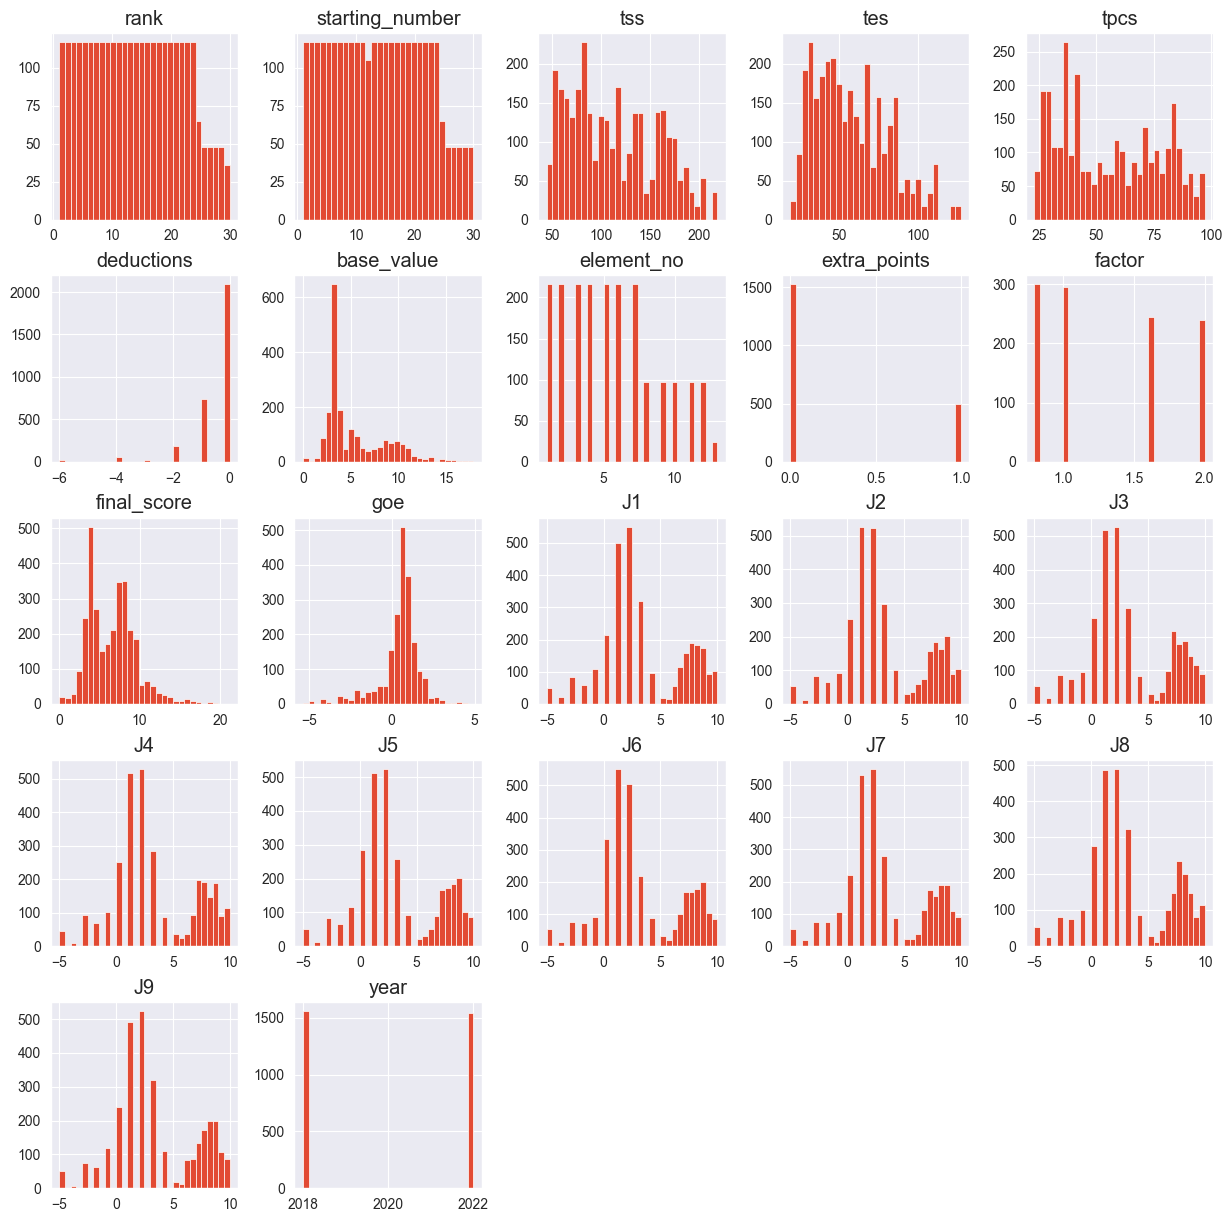

In [67]:
data_df[numeric_cols].hist(figsize=(15, 15), bins=30)
plt.show()

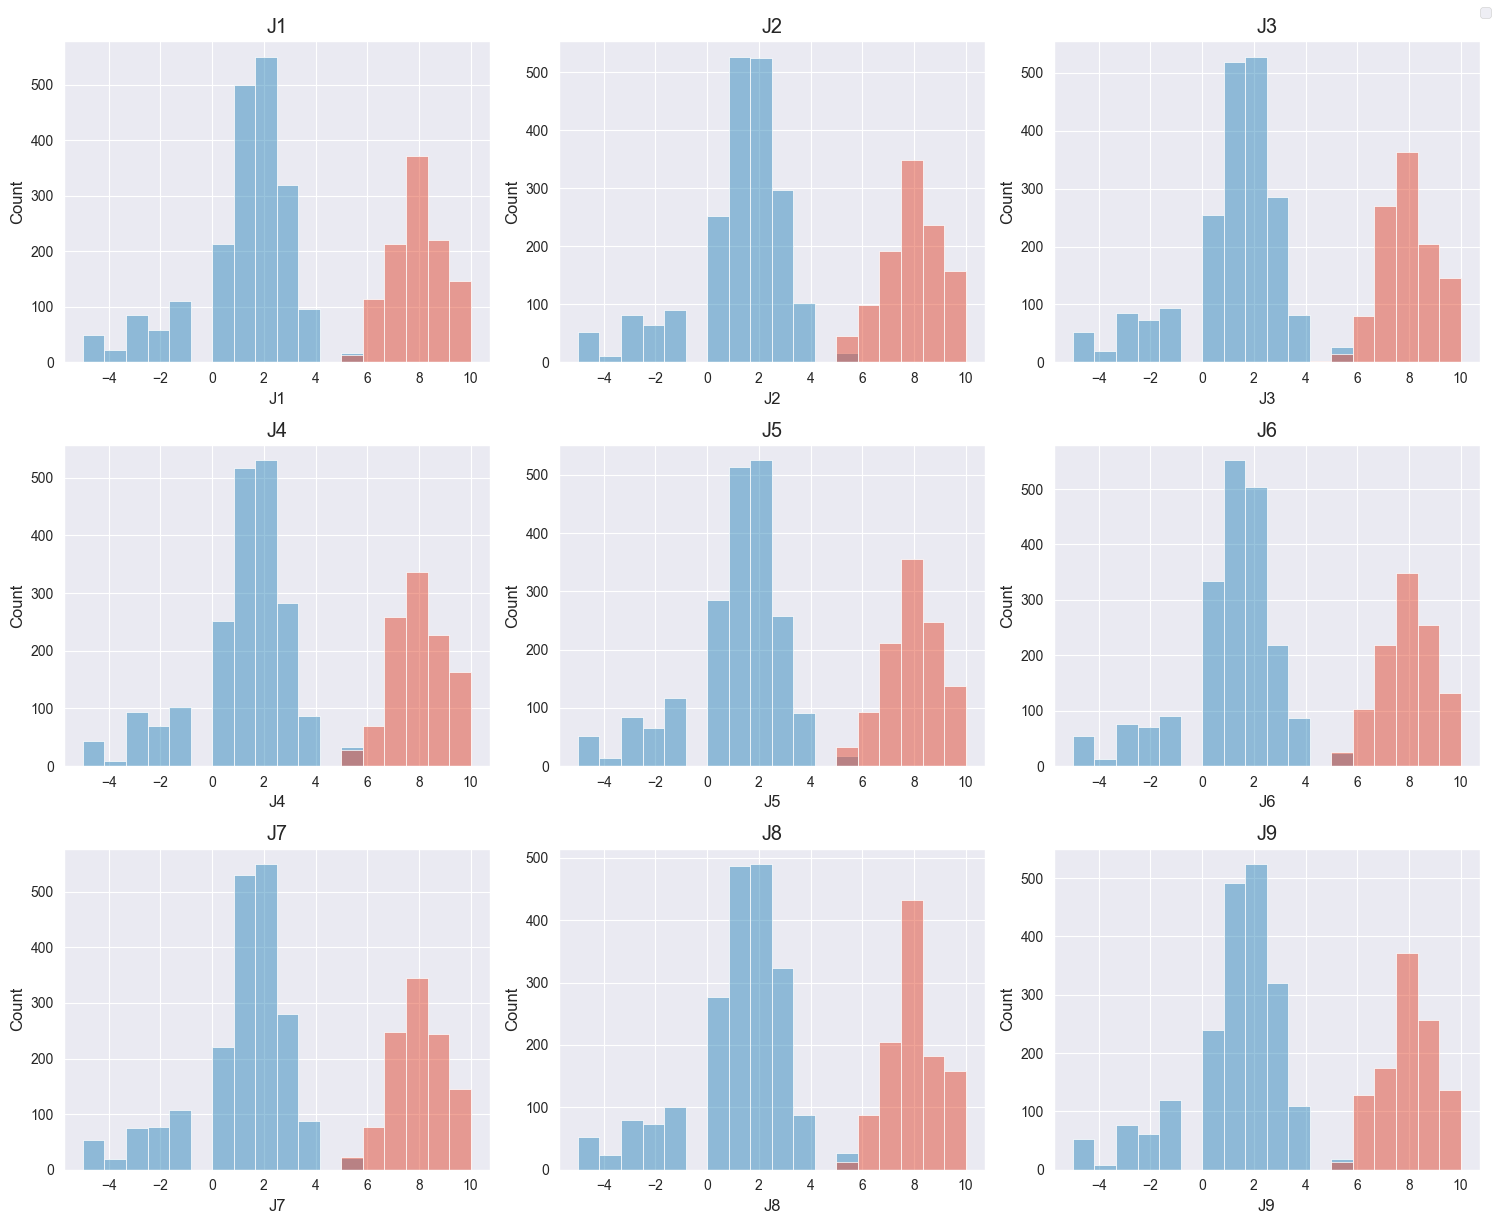

In [75]:
# why is judge col bimodal
judge_cols = [f"J{i}" for i in range(1,10)]

n_cols = 3
n_plots = len(numeric_cols)
n_rows = math.ceil(n_plots / n_cols)

fig, axes = plt.subplots(n_rows, n_cols, figsize=(5 * n_cols, 4 * n_rows))
axes = axes.flatten()

for i, c in enumerate(judge_cols):
    sns.histplot(
        data=data_df, 
        x=judge_cols[i],
        hue="is_element",
        ax=axes[i]
    )
    axes[i].set_title(c)
    axes[i].legend_.remove()  # remove repeated legends

# Remove unused subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

# Add one shared legend
handles, labels = axes[0].get_legend_handles_labels()
fig.legend(handles, labels, loc="upper right")

plt.tight_layout()
plt.show()


**Observations:**
- **Judge Scores** 
    - look relatively normal but bimodal suddenly
        - second hump is cause of element and program components; otherwise it all looks p normal
- **Extra Points**
    - most elements are not extra points
    - Question: How does # of extra point elements impact your score?
- **TSS/TES/TPCS**
    - Should remove one of these since they are clearly linear dependent (probably TSS)
    - ACTION: TES / TPCS feature? manually looking at score sheets, seems like people with high TES / TPCS tend to do better?
- **DEDUCTIONS**
    - Almost nobody gets a deduction
    - ACTION: Where in the program do deductions happen?
- **BASE VALUE**
    - Fat right tail
    - ACTION: Where are the high base value elements located in the program?
    - ACTION: How many high base value elements do people do?
    - ACTION: Base Value conditioned on rankings?
    - ACTION: Perhaps the people doing the super hard jumps are the people are way more talented. Does having a high base val mean that judges will score you higher on average?
        - ACTION: Maybe add total base val z-score feature? maybe ordinal ranking of total base val score?
- **GOE**
    - Thin tails, mostly clustered near 0
    - ACTION: How does GOE correlate with Base Value (presumably negative)?
    - ACTION: GOE conditioned on rankings?
- **FACTOR**
    - ACTION: idrk what this is yet 
    - DONE: seems like it is a thing to balance out the execution score and the performance component scores.
- **is_mens**
    - ACTION: Group by gender and see what patterns might appear; violin plot etc.
    - DONE: see below

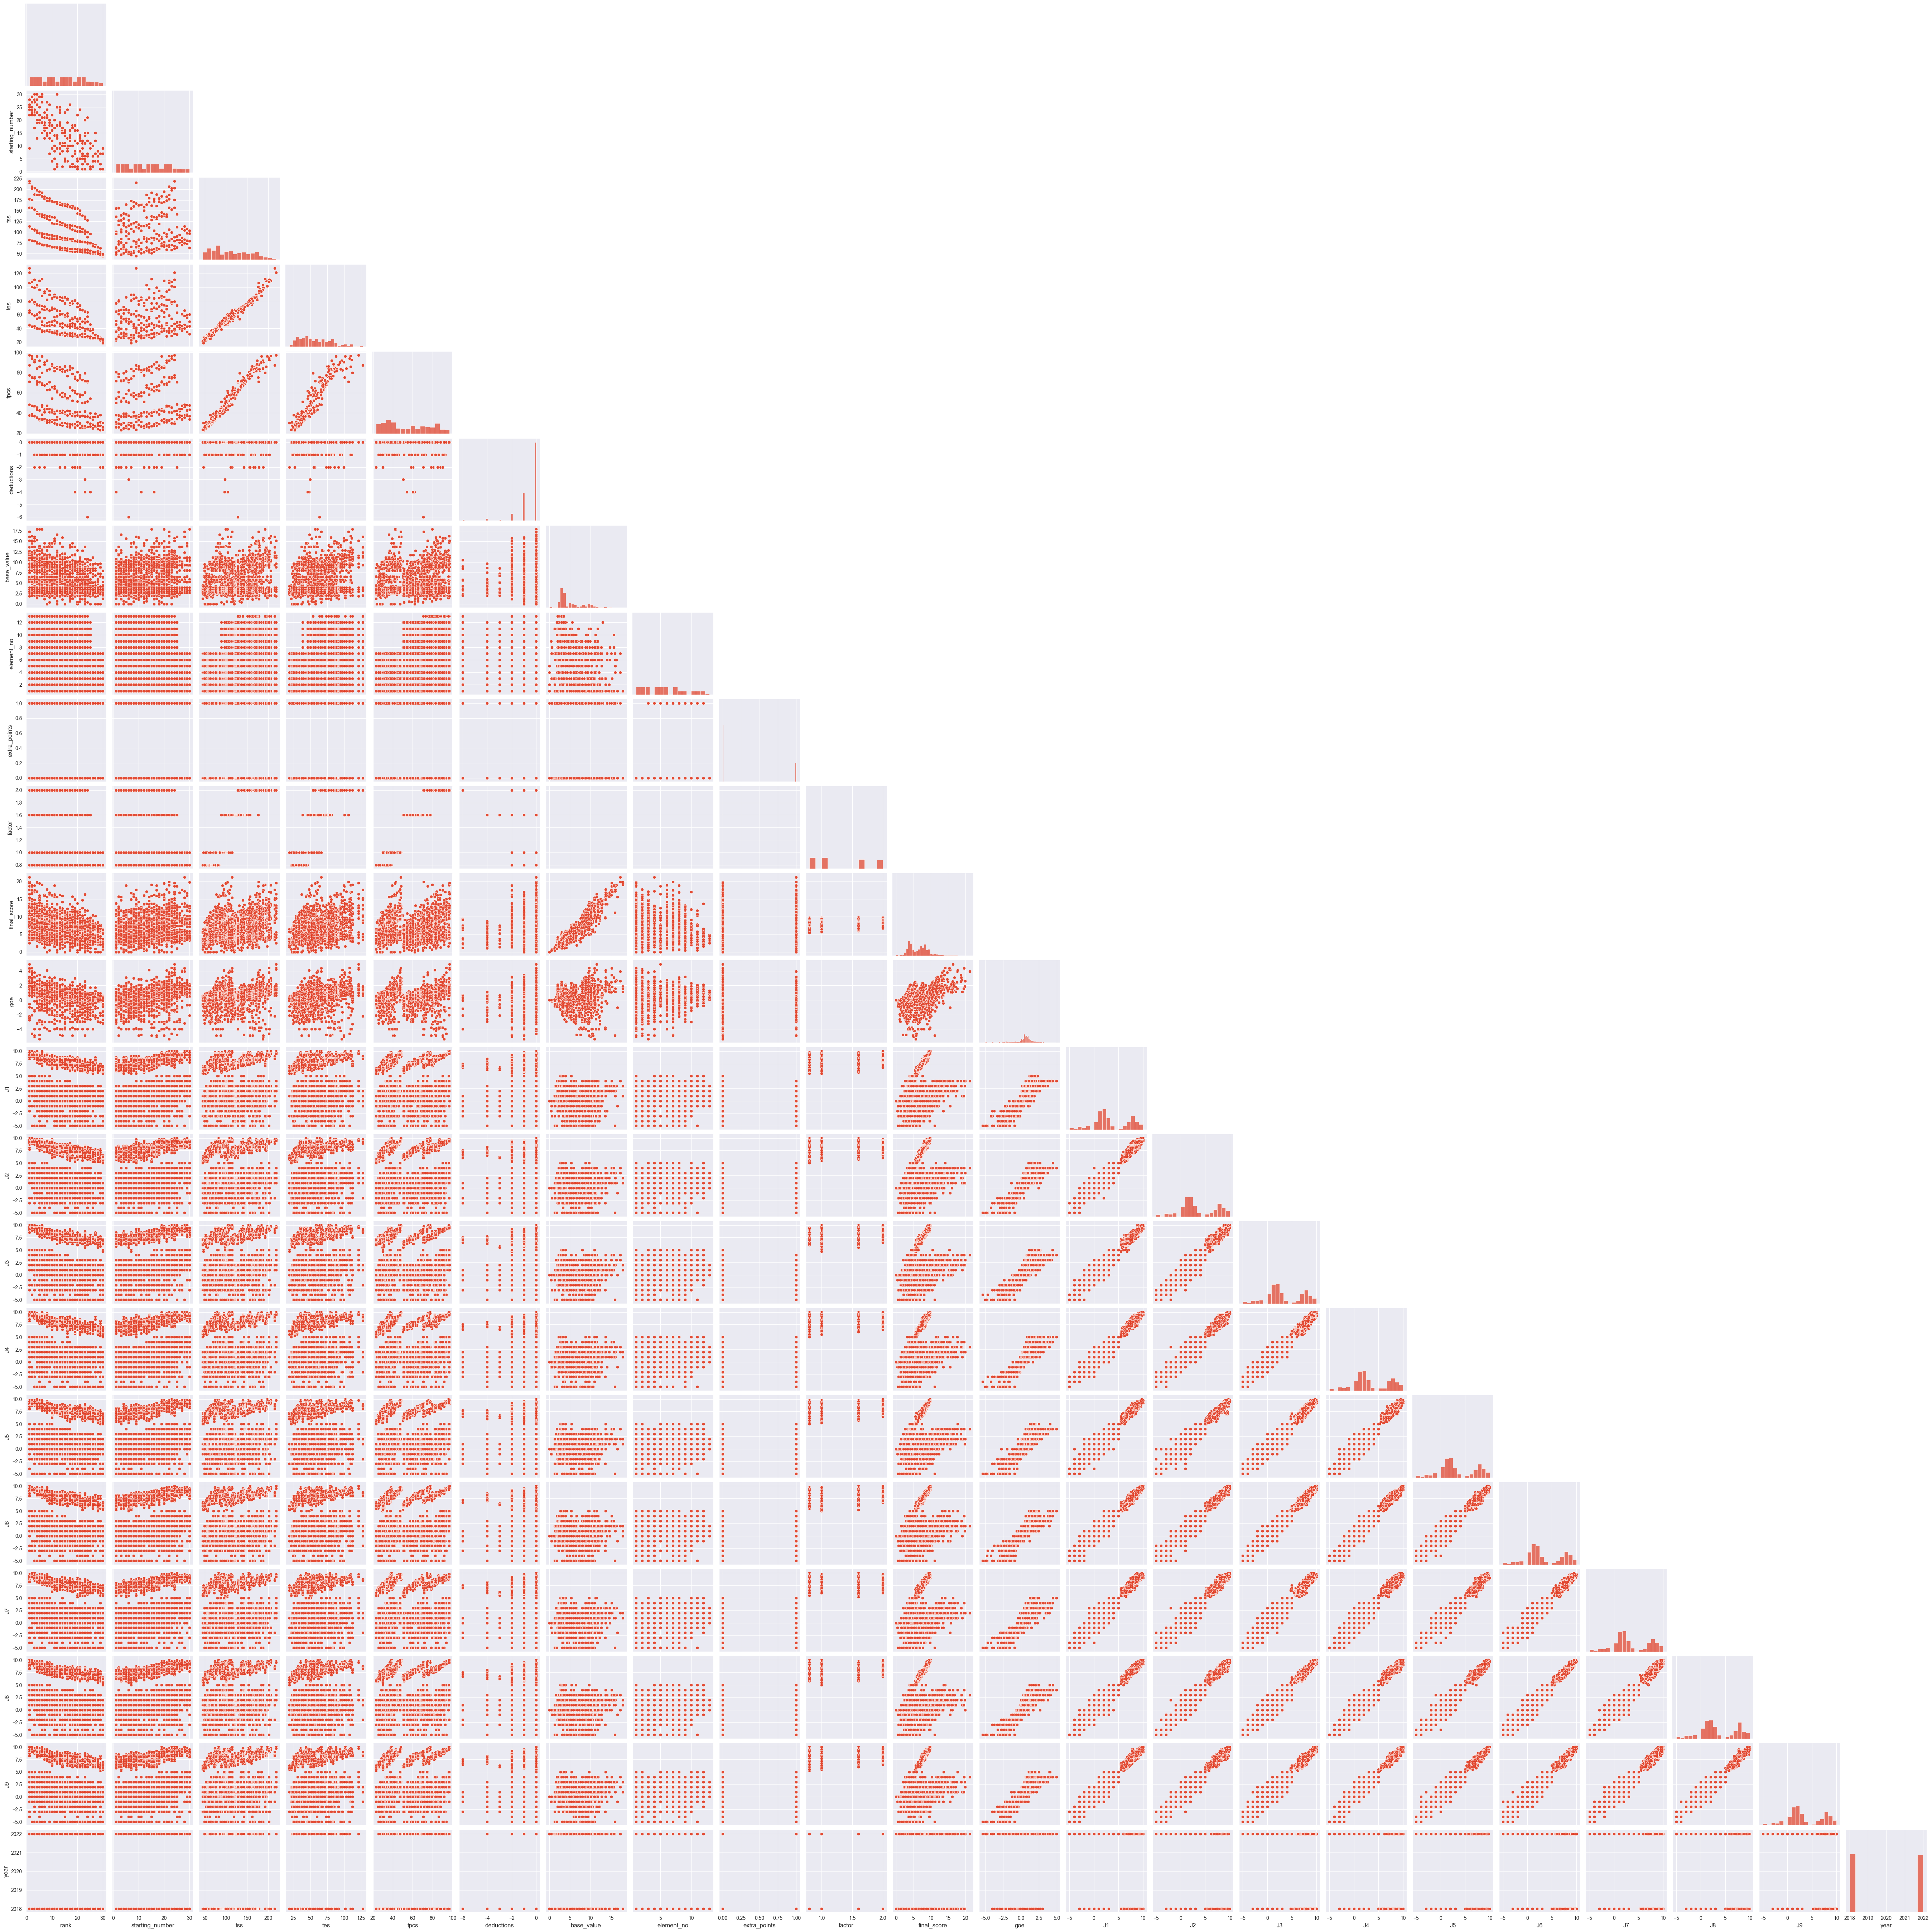

In [76]:
sns.pairplot(data_df[numeric_cols], corner=True)

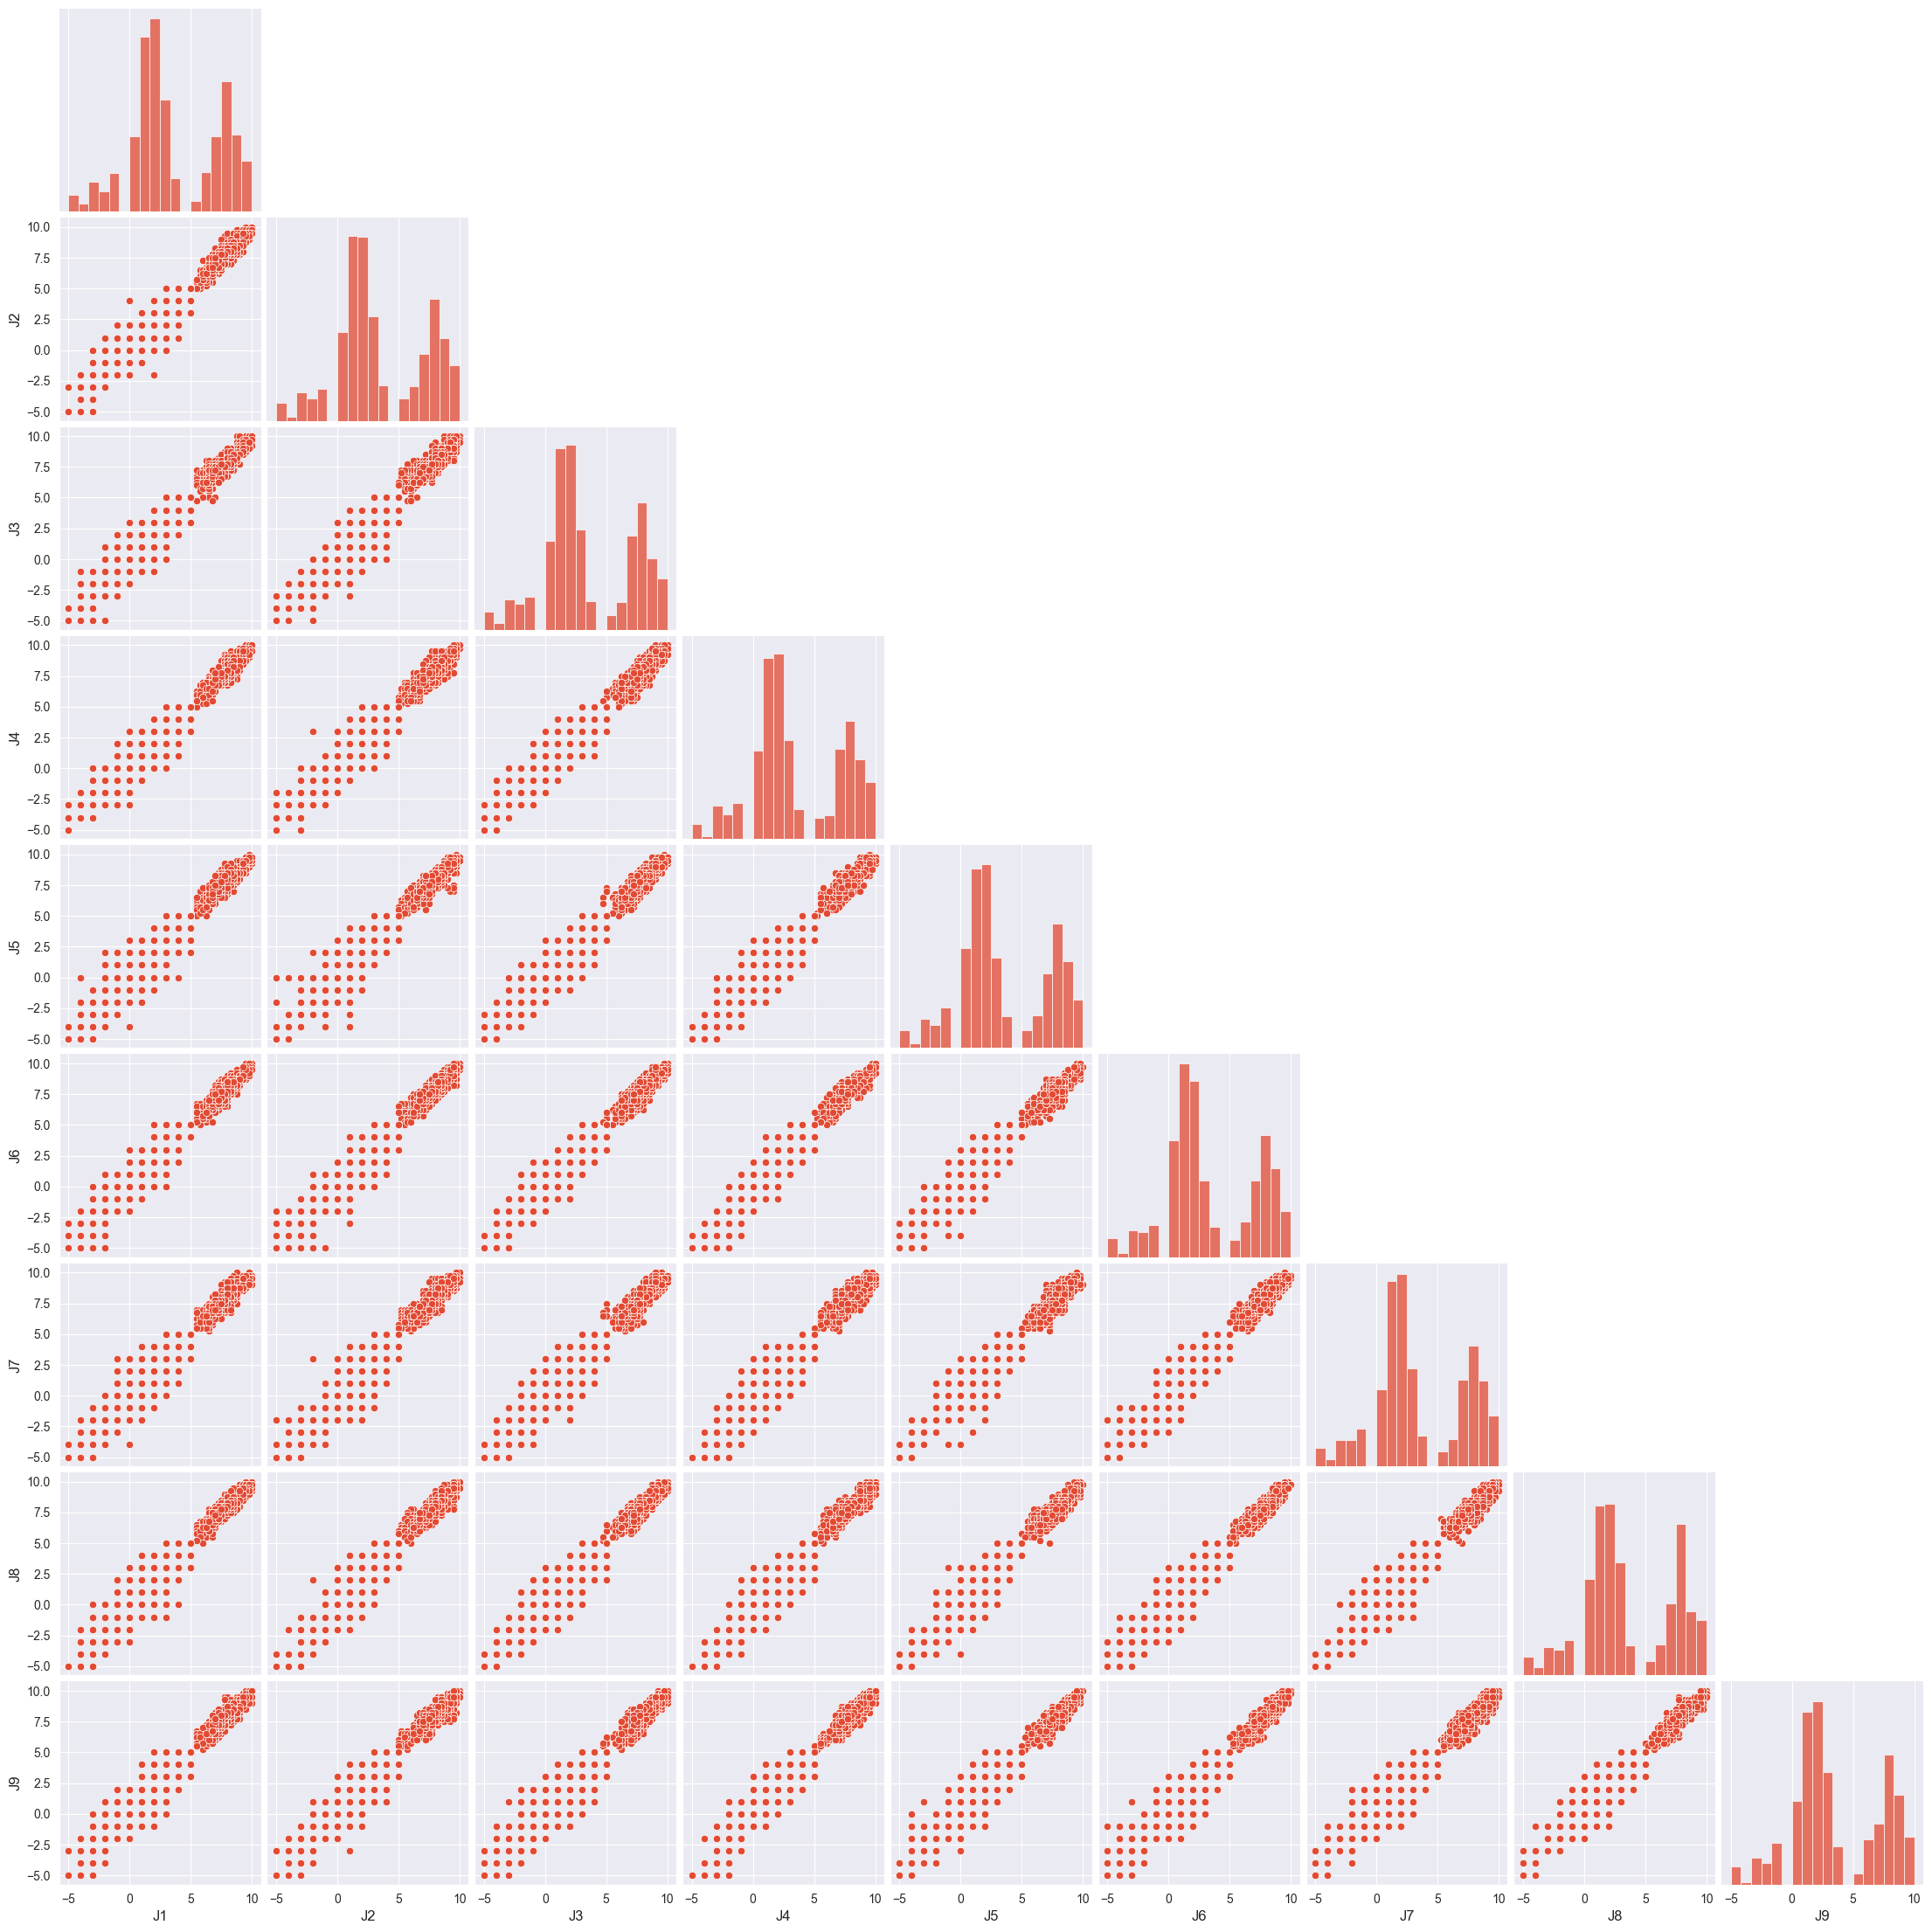

In [77]:
sns.pairplot(data_df[[c for c in numeric_cols if "J" in c]], corner=True)
plt.show()

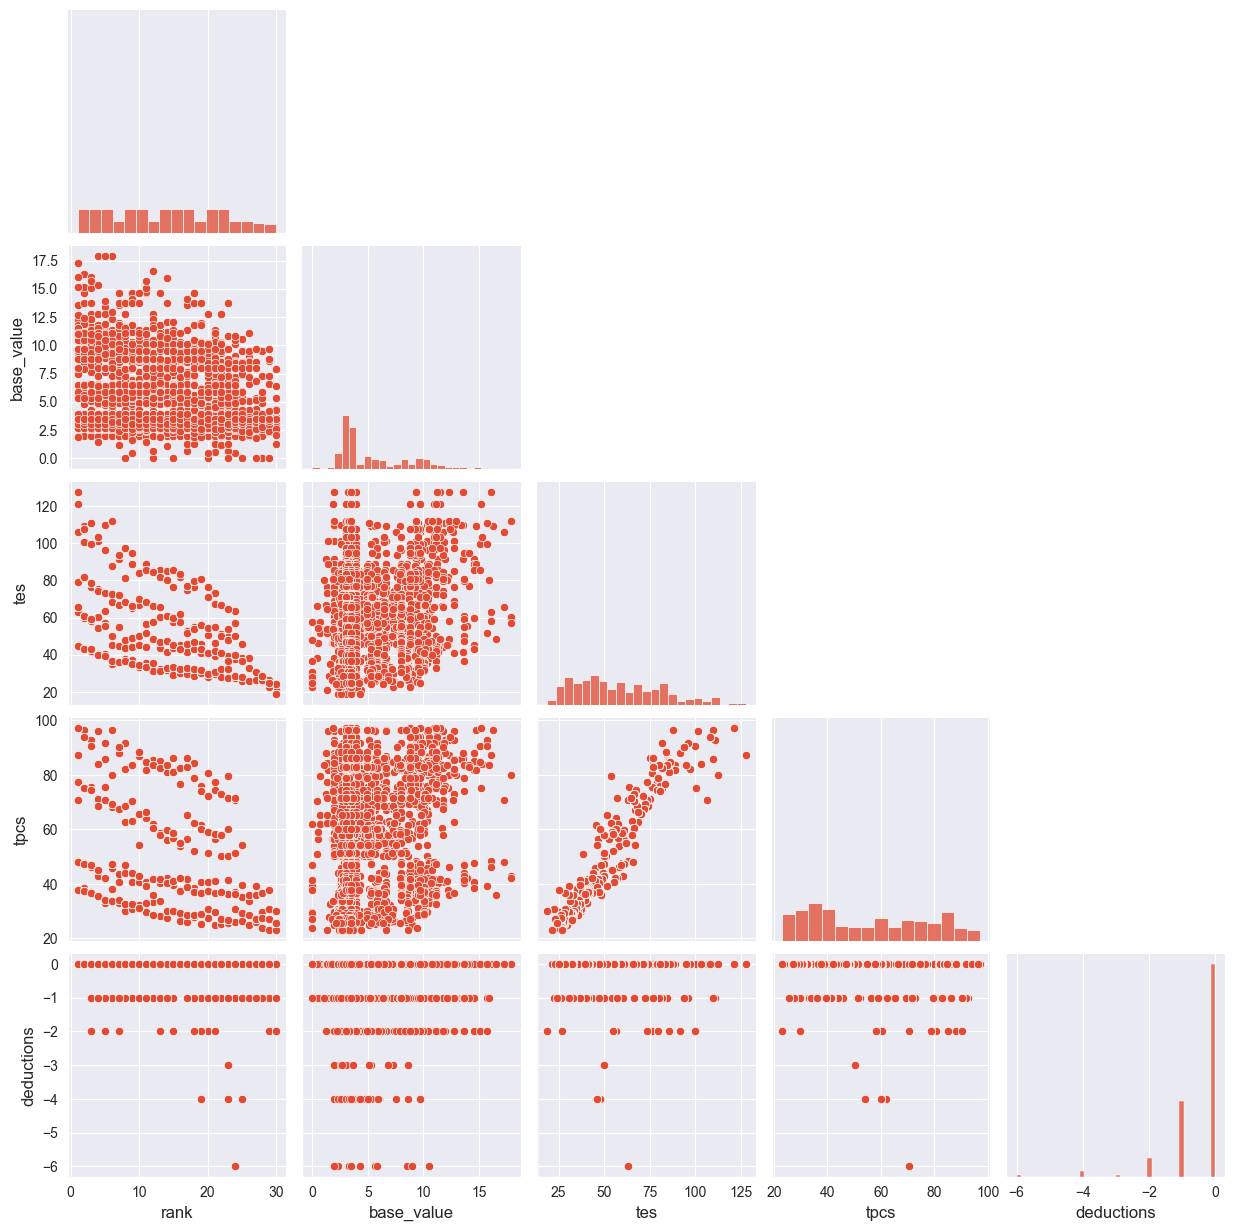

In [78]:
sns.pairplot(data_df[["rank", "base_value", "tes", "tpcs", "deductions"]], corner=True)
plt.show()

**Observations/Actions:**
- **Judge Scores**
    - Are the extra points are baked in already to the judge scores? (ACTION: violinplot comparing the distributions of is_extra)
    - Recalling the permutation trick, the fact that these all look the same makes more sense. They are all drawn from the same mixed distribution?
- **Base Val**
    - Band of base val when compared rank (everyone doing the basic stuff)
    - ACTION: new feature per person is like highest ranked base val component or something
- **TES**
    - Distinct Lines of TES/TPCS/TSS wrt rank
        - ACTION: my guess is that this is women vs men; off inspection top women scorers are scoring much less than top men scorers (DONE)

### Base Val

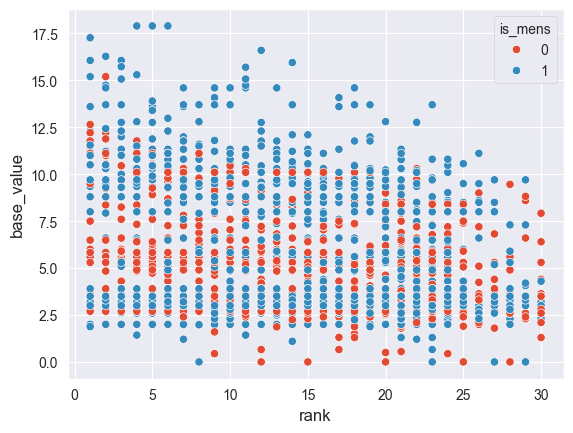

In [18]:
sns.scatterplot(data=data_df, x="rank", y="base_value", hue="is_mens")
plt.show()

### TES

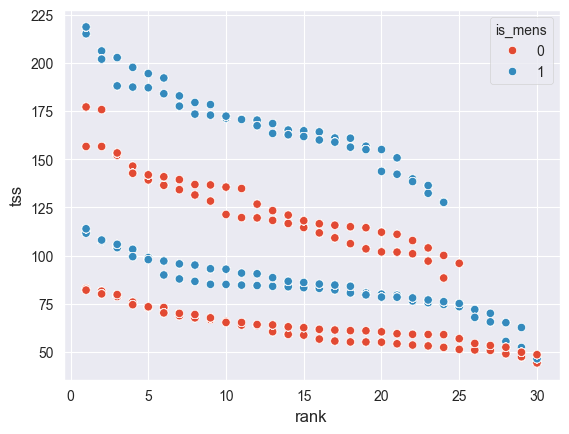

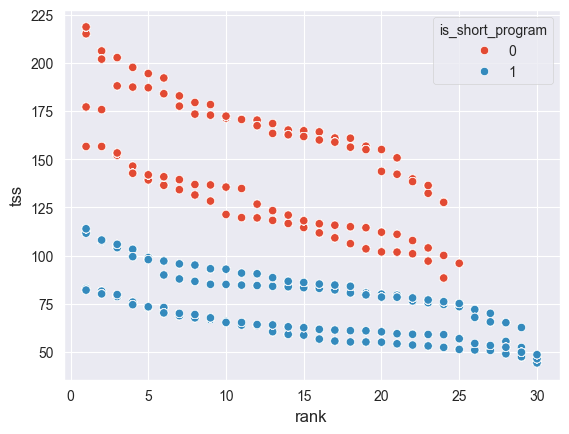

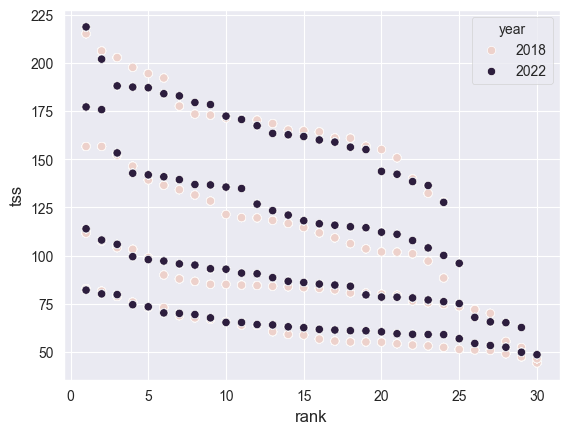

In [79]:
# in tss vs rank plot, the lines are distinct
sns.scatterplot(data=data_df, x="rank", y="tss", hue="is_mens")
plt.show()

# distinct lines are due to gender and due to free vs short program
sns.scatterplot(data=data_df, x="rank", y="tss", hue="is_short_program")
plt.show()

sns.scatterplot(data=data_df, x="rank", y="tss", hue="year")
plt.show()

Intuitively this should make sense that the free skate is much higher is score; it literally is longer.

### Gender Split

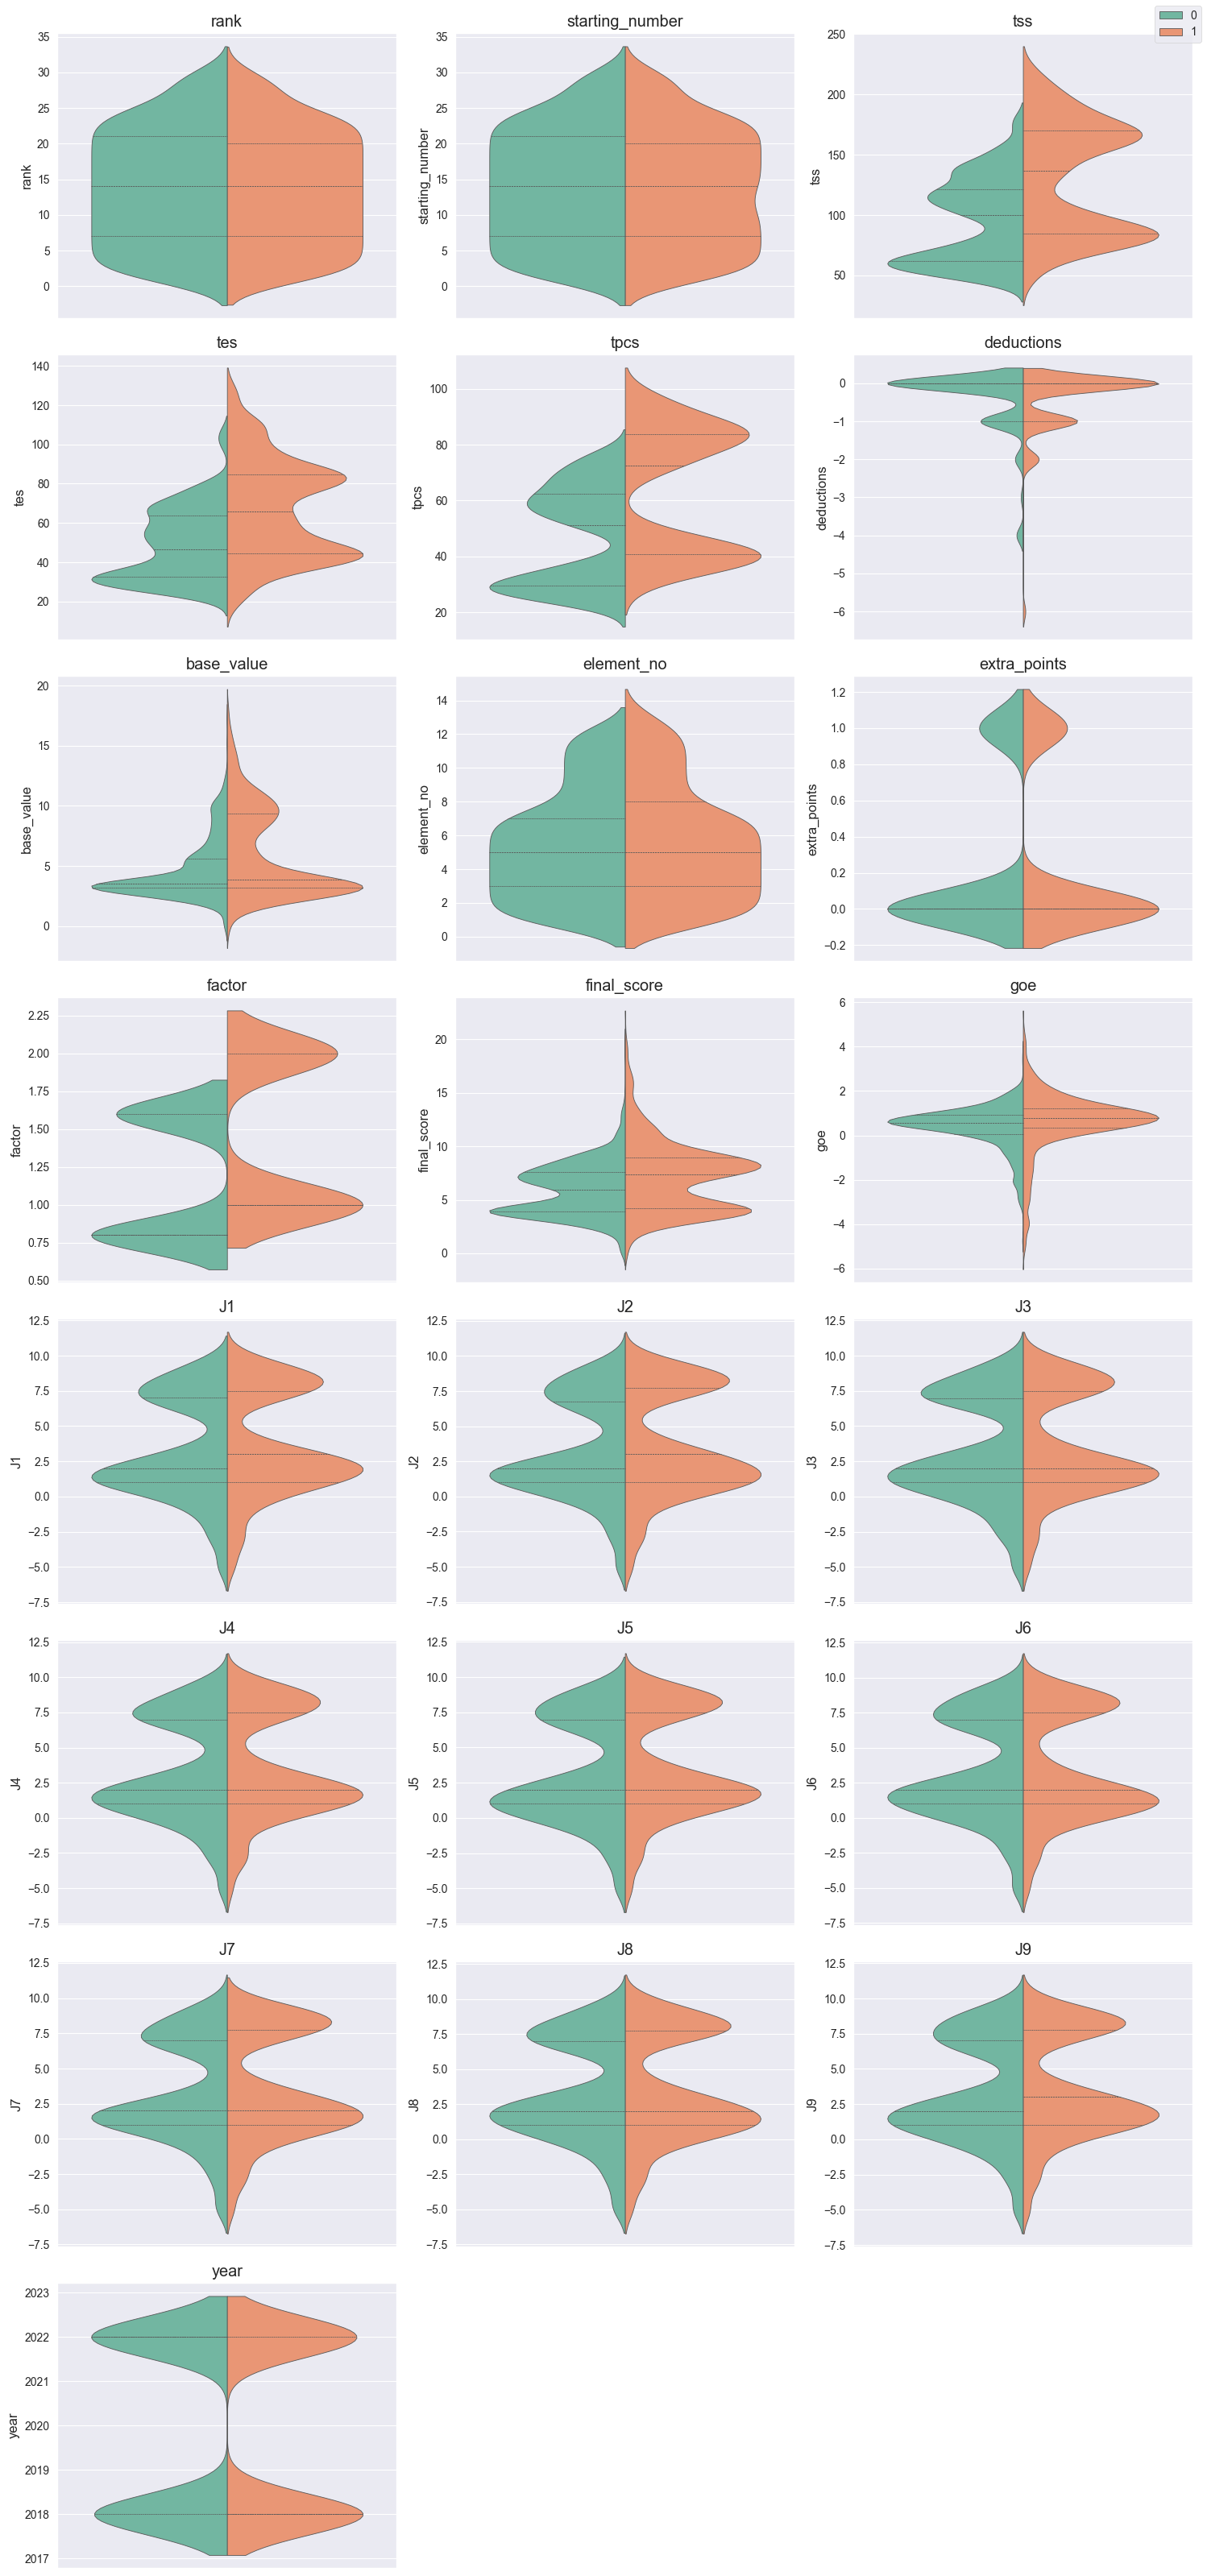

In [80]:
n_cols = 3
n_plots = len(numeric_cols)
n_rows = math.ceil(n_plots / n_cols)

fig, axes = plt.subplots(n_rows, n_cols, figsize=(5 * n_cols, 4 * n_rows))
axes = axes.flatten()  # make indexing easy

for i, c in enumerate(numeric_cols):
    sns.violinplot(
        y=c,
        hue="is_mens",
        data=data_df,
        split=True,
        inner="quartile",
        palette="Set2",
        ax=axes[i]
    )
    axes[i].set_title(c)
    axes[i].legend_.remove()  # remove repeated legends

# Remove unused subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

# Add one shared legend
handles, labels = axes[0].get_legend_handles_labels()
fig.legend(handles, labels, loc="upper right")

plt.tight_layout()
plt.show()


### Short Program Split

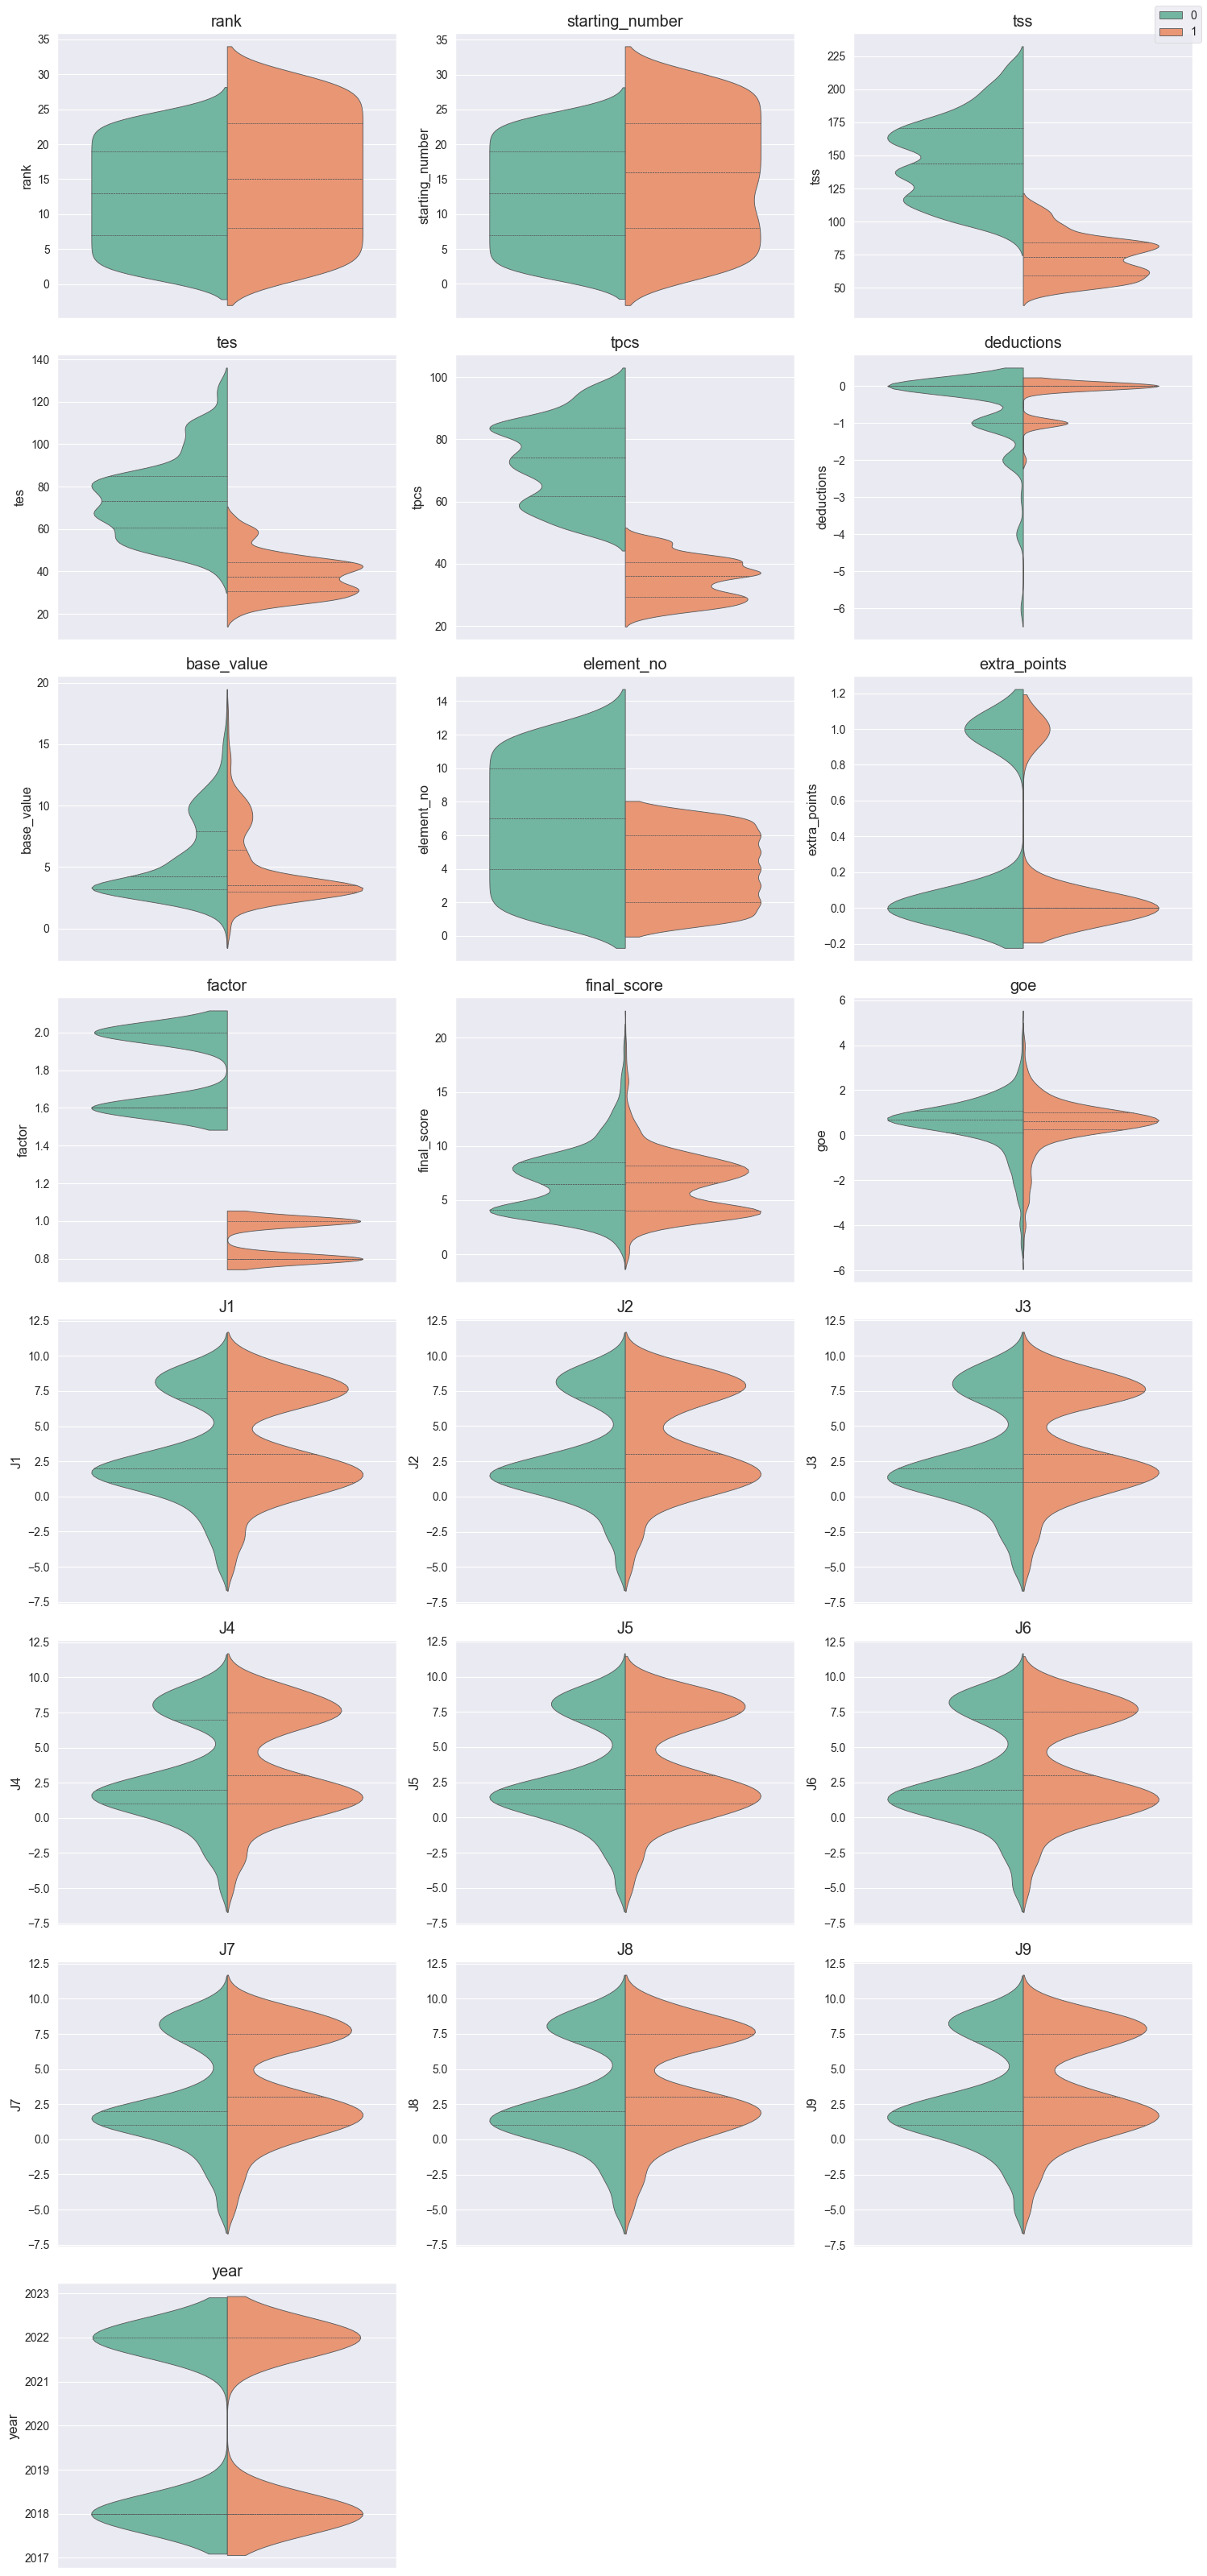

In [81]:
n_cols = 3
n_plots = len(numeric_cols)
n_rows = math.ceil(n_plots / n_cols)

fig, axes = plt.subplots(n_rows, n_cols, figsize=(5 * n_cols, 4 * n_rows))
axes = axes.flatten()  # make indexing easy

for i, c in enumerate(numeric_cols):
    sns.violinplot(
        y=c,
        hue="is_short_program",
        data=data_df,
        split=True,
        inner="quartile",
        palette="Set2",
        ax=axes[i]
    )
    axes[i].set_title(c)
    axes[i].legend_.remove()  # remove repeated legends

# Remove unused subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

# Add one shared legend
handles, labels = axes[0].get_legend_handles_labels()
fig.legend(handles, labels, loc="upper right")

plt.tight_layout()
plt.show()


### Extra Points Split

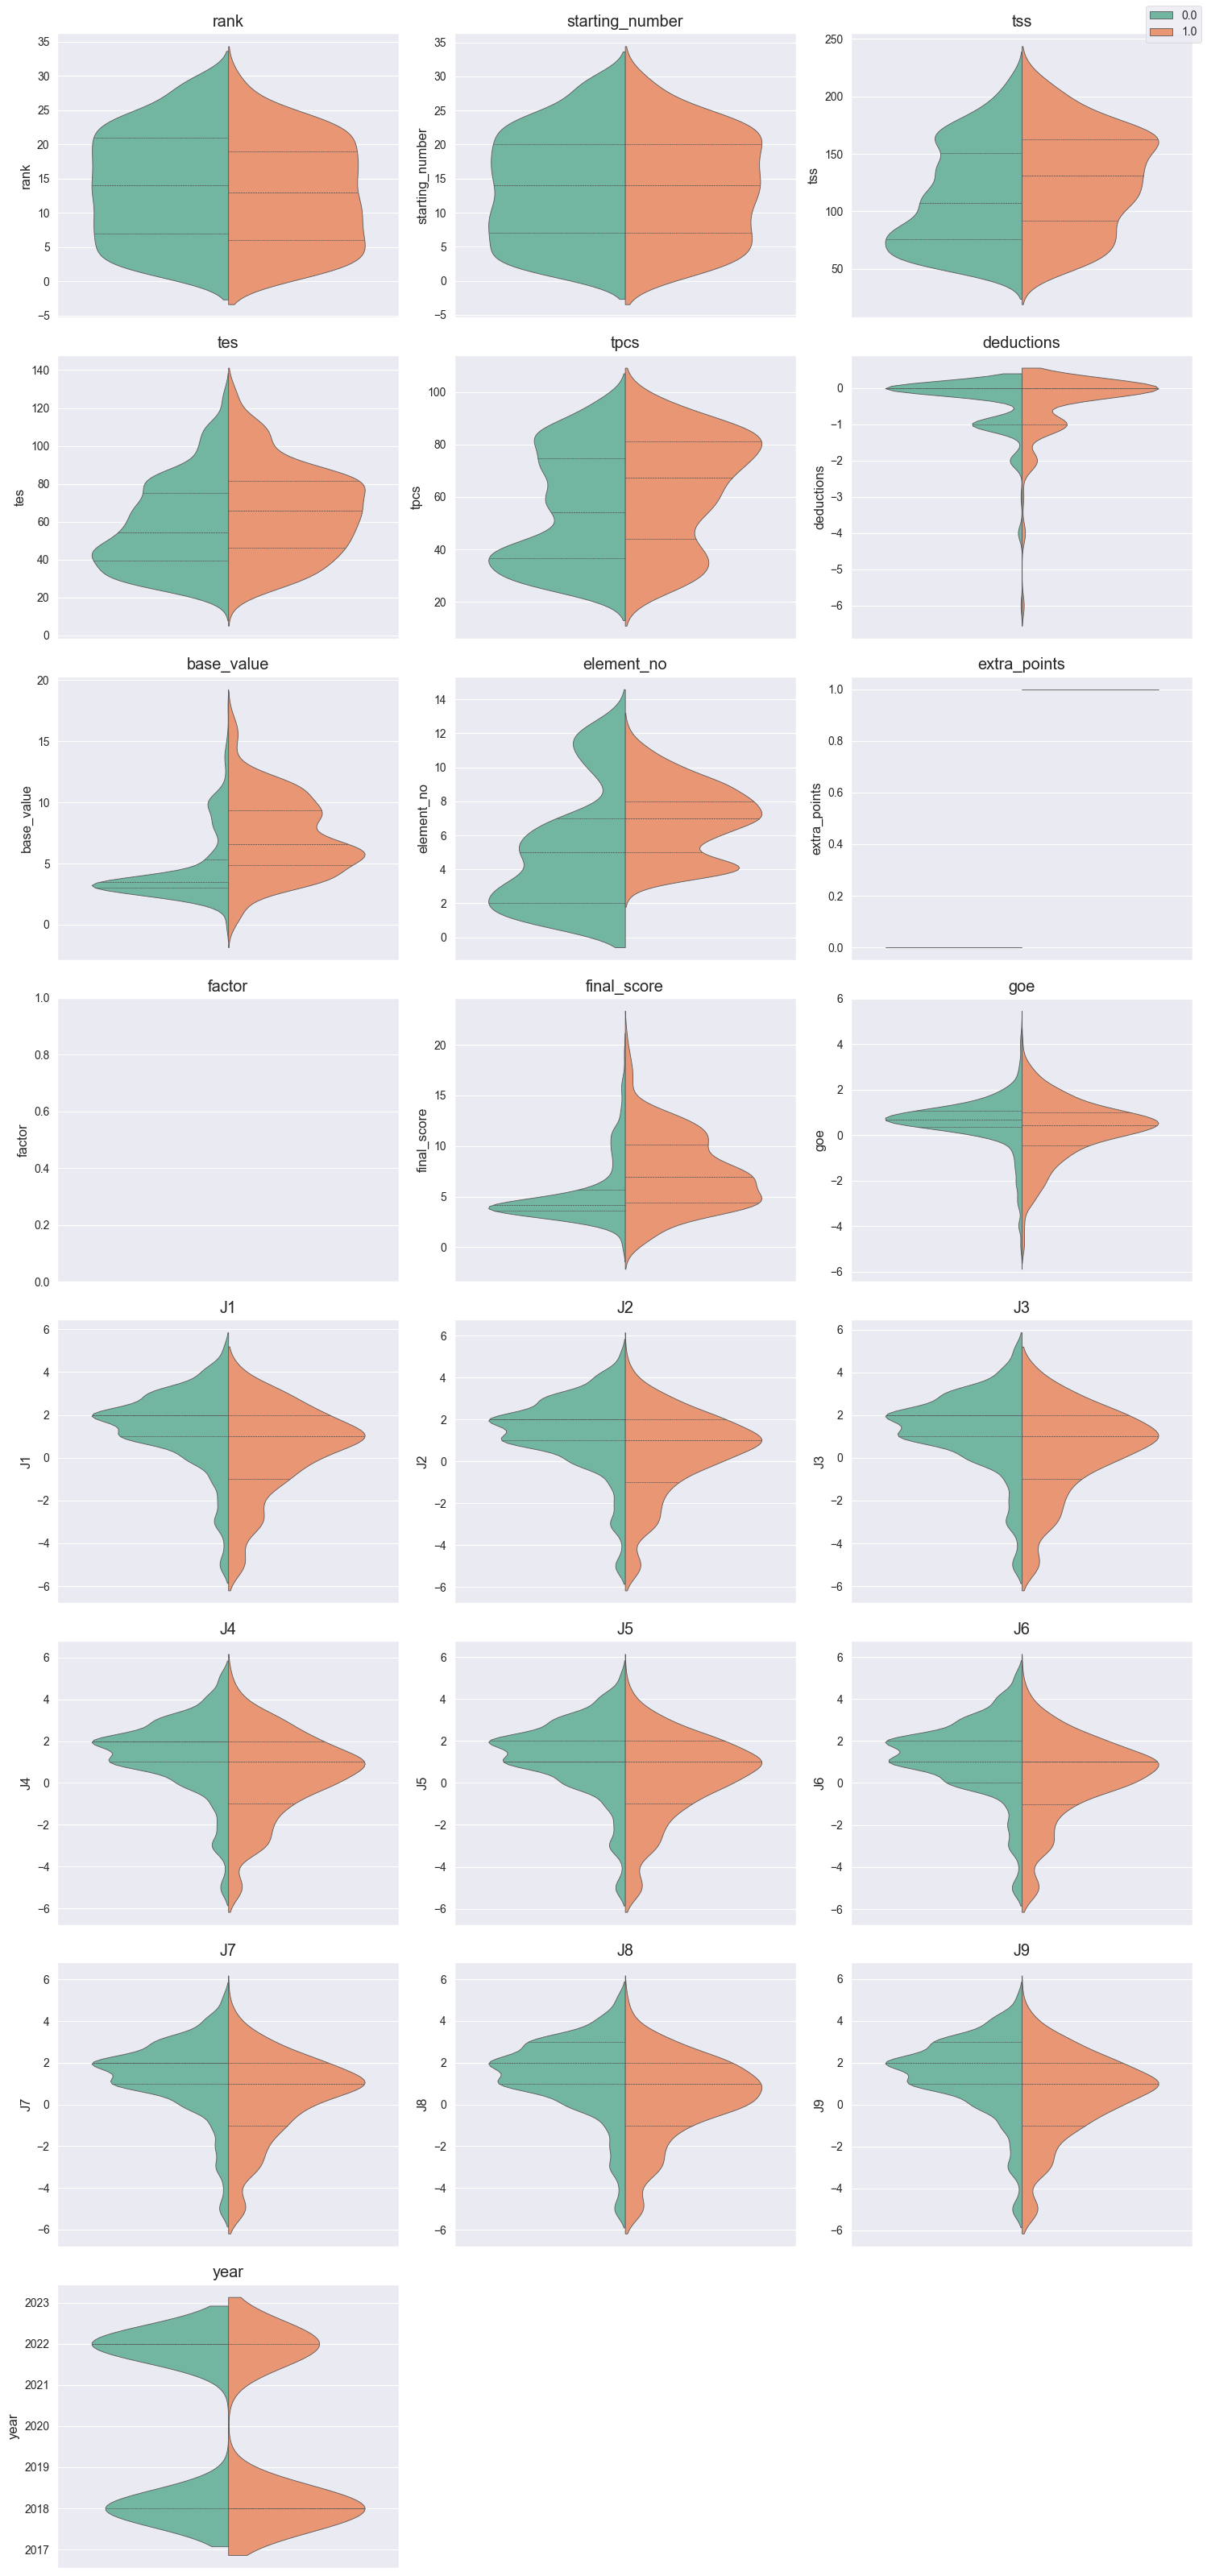

In [82]:
n_cols = 3
n_plots = len(numeric_cols)
n_rows = math.ceil(n_plots / n_cols)

fig, axes = plt.subplots(n_rows, n_cols, figsize=(5 * n_cols, 4 * n_rows))
axes = axes.flatten()  # make indexing easy

for i, c in enumerate(numeric_cols):
    sns.violinplot(
        y=c,
        hue="extra_points",
        data=data_df,
        split=True,
        inner="quartile",
        palette="Set2",
        ax=axes[i]
    )
    axes[i].set_title(c)
    axes[i].legend_.remove()  # remove repeated legends

# Remove unused subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

# Add one shared legend
handles, labels = axes[0].get_legend_handles_labels()
fig.legend(handles, labels, loc="upper right")

plt.tight_layout()
plt.show()


### Final Score

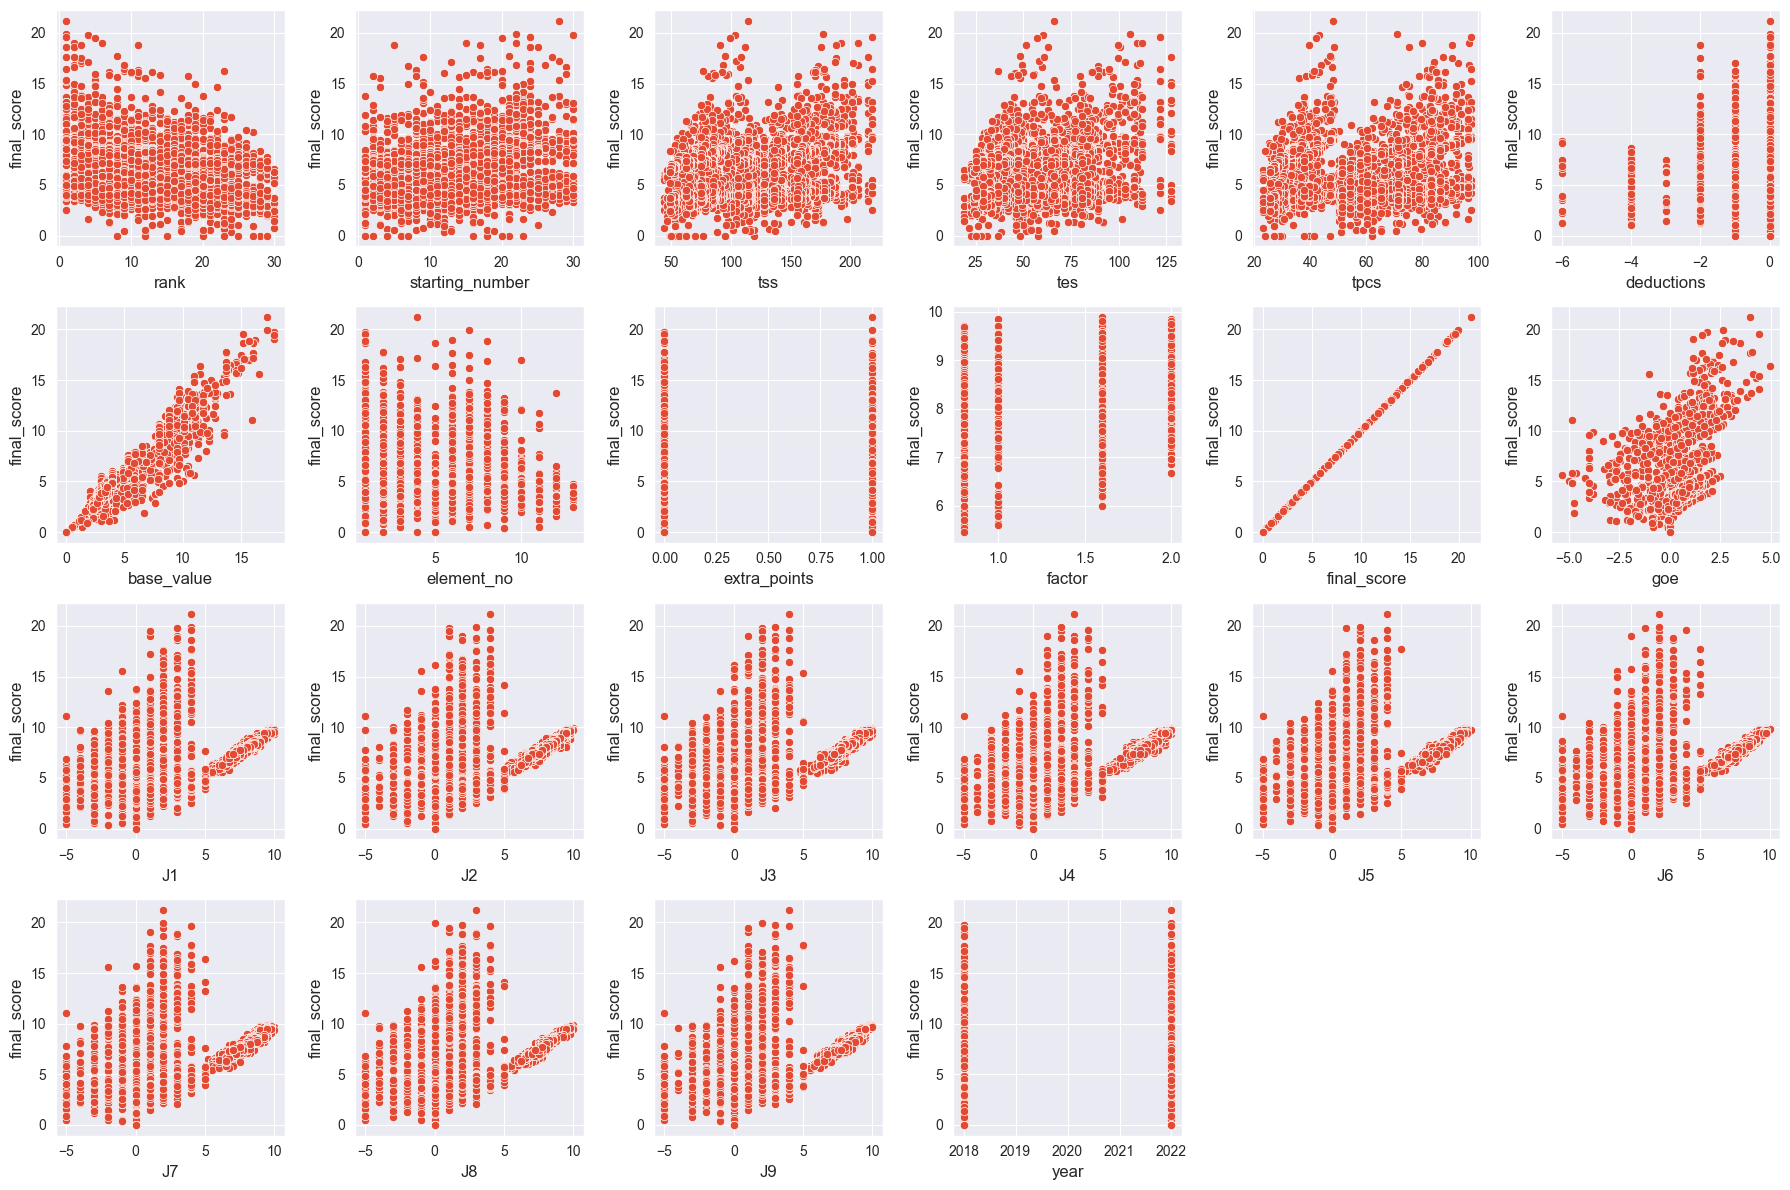

In [83]:
pairplot_list_against_list(data_df, numeric_cols, ["final_score"])

## Categorical Variables

In [84]:
data_df["noc"].value_counts()

noc
JPN    322
USA    322
CAN    200
KOR    187
ROC    174
OAR    147
CHN    130
ITA    129
AUS    100
FRA     99
BEL     88
GEO     88
GER     88
SUI     87
ISR     72
CZE     71
LAT     71
UKR     65
FIN     58
AZE     58
BLR     58
KAZ     53
SWE     53
ESP     42
EST     41
UZB     30
MEX     29
BRA     29
BUL     29
POL     29
SVK     29
AUT     29
NED     29
HUN     29
PHI     12
MAS     12
GBR     12
Name: count, dtype: int64

# Interesting Questions

1. Controlling for skill or something like that, is it +ev to do lots of extra jumps and have your hardest jumps be extra points?
2. Do judges grade skilled skaters more favorablely?
3. Do judges grade "easy" elements all the same and then "hard" elements are the differentiating factor? (smth smth variance of so-called easy jumps vs variance of so-called hard jumps?)
4. Reproducing similar study questions like which judges are being dropped, trying to identify judges across the permutations

# Modeling

In [89]:
data_df.head(17)

rank               name  noc  starting_number      tss     tes    tpcs  \
0      1  Medvedeva Evgenia  OAR               24 156.6500 79.1800 77.4700   
1      1  Medvedeva Evgenia  OAR               24 156.6500 79.1800 77.4700   
2      1  Medvedeva Evgenia  OAR               24 156.6500 79.1800 77.4700   
3      1  Medvedeva Evgenia  OAR               24 156.6500 79.1800 77.4700   
4      1  Medvedeva Evgenia  OAR               24 156.6500 79.1800 77.4700   
5      1  Medvedeva Evgenia  OAR               24 156.6500 79.1800 77.4700   
6      1  Medvedeva Evgenia  OAR               24 156.6500 79.1800 77.4700   
7      1  Medvedeva Evgenia  OAR               24 156.6500 79.1800 77.4700   
8      1  Medvedeva Evgenia  OAR               24 156.6500 79.1800 77.4700   
9      1  Medvedeva Evgenia  OAR               24 156.6500 79.1800 77.4700   
10     1  Medvedeva Evgenia  OAR               24 156.6500 79.1800 77.4700   
11     1  Medvedeva Evgenia  OAR               24 156.6500 79.1800 77.4700   
12     1  Medvedeva Evgenia  OAR               24 156.6500 79.1800 77.4700   
13     1  Medvedeva Evgenia  OAR               24 156.6500 79.1800 77.4700   
14     1  Medvedeva Evgenia  OAR               24 156.6500 79.1800 77.4700   
15     1  Medvedeva Evgenia  OAR               24 156.6500 79.1800 77.4700   
16     1  Medvedeva Evgenia  OAR               24 156.6500 79.1800 77.4700   

    deductions  base_value   element  element_no  extra_points  factor  \
0       0.0000      9.6000     3F+3T      1.0000        0.0000     NaN   
1       0.0000      6.0000       3Lz      2.0000        0.0000     NaN   
2       0.0000      3.5000   FCCoSp4      3.0000        0.0000     NaN   
3       0.0000      3.9000     StSq4      4.0000        0.0000     NaN   
4       0.0000      5.8300        3F      5.0000        1.0000     NaN   
5       0.0000      5.6100       3Lo      6.0000        1.0000     NaN   
6       0.0000      6.4900  2A+2T+2T      7.0000        1.0000     NaN   
7       0.0000      9.5700     3S+3T      8.0000        1.0000     NaN   
8       0.0000      3.6300        2A      9.0000        1.0000     NaN   
9       0.0000      2.0000     ChSq1     10.0000        0.0000     NaN   
10      0.0000      3.5000    CCoSp4     11.0000        0.0000     NaN   
11      0.0000      2.7000      LSp4     12.0000        0.0000     NaN   
12      0.0000         NaN       NaN         NaN           NaN  1.6000   
13      0.0000         NaN       NaN         NaN           NaN  1.6000   
14      0.0000         NaN       NaN         NaN           NaN  1.6000   
15      0.0000         NaN       NaN         NaN           NaN  1.6000   
16      0.0000         NaN       NaN         NaN           NaN  1.6000   

    final_score    goe info            program_component     J1      J2  \
0       11.0000 1.4000  NaN                          NaN 2.0000  2.0000   
1        7.6000 1.6000  NaN                          NaN 2.0000  3.0000   
2        4.5700 1.0700  NaN                          NaN 2.0000  2.0000   
3        5.9000 2.0000  NaN                          NaN 2.0000  3.0000   
4        7.7300 1.9000  NaN                          NaN 3.0000  3.0000   
5        7.3100 1.7000  NaN                          NaN 3.0000  2.0000   
6        7.2800 0.7900  NaN                          NaN 1.0000  1.0000   
7       11.1700 1.6000  NaN                          NaN 1.0000  3.0000   
8        4.3400 0.7100  NaN                          NaN 1.0000  1.0000   
9        3.8000 1.8000  NaN                          NaN 2.0000  3.0000   
10       4.6400 1.1400  NaN                          NaN 2.0000  2.0000   
11       3.8400 1.1400  NaN                          NaN 3.0000  2.0000   
12       9.7100    NaN  NaN                  Composition 9.5000 10.0000   
13       9.8900    NaN  NaN  Interpretation of the Music 9.7500 10.0000   
14       9.8200    NaN  NaN                  Performance 9.5000  9.7500   
15       9.5700    NaN  NaN               Skating Skills 9.5000  9

In [107]:
agg_df = (
    data_df
        .groupby(["name", "year", "is_short_program", "is_mens", "is_element"])
        .agg(
            {f"J{i}" : "sum" for i in range(1,10)} |
            {f"judge{i}_nat" : "first" for i in range(1,10)} |
            {f"judge{i}_same" : "first" for i in range(1,10)} | 
            {
                "base_value" : "sum",
                "factor" : "first"
            }
        )
        .fillna(
            {
                "factor" : 1
            }
        )
        .reset_index()       
)

for i in range(1, 10):
    agg_df[f"J{i}_final"] = (agg_df[f"J{i}"] + agg_df["base_value"]) * agg_df["factor"]


In [108]:
agg_df.head()

name  year  is_short_program  is_mens  is_element      J1  \
0    Aliev Dmitri  2018                 0        1           0 43.2500   
1    Aliev Dmitri  2018                 0        1           1  8.0000   
2    Aliev Dmitri  2018                 1        1           0 39.2500   
3    Aliev Dmitri  2018                 1        1           1  5.0000   
4  Austman Larkyn  2018                 1        0           0 32.0000   

       J2      J3      J4      J5      J6      J7      J8      J9 judge1_nat  \
0 42.2500 42.2500 43.7500 42.2500 43.2500 41.0000 42.2500 42.5000        KAZ   
1  5.0000  6.0000  5.0000  9.0000  4.0000  3.0000  0.0000  6.0000        KAZ   
2 42.7500 41.2500 42.0000 43.5000 42.5000 44.7500 40.5000 41.5000        ESP   
3  8.0000 10.0000 10.0000 10.0000 10.0000 11.0000  9.0000  7.0000        ESP   
4 31.0000 38.5000 32.5000 35.2500 32.2500 30.7500 34.7500 33.0000        SVK   

  judge2_nat judge3_nat judge4_nat judge5_nat judge6_nat judge7_nat  \
0        USA        UZB        JPN        ISR        ROC        CHN   
1        USA        UZB        JPN        ISR        ROC        CHN   
2        LAT        FRA        UZB        JPN        ROC        USA   
3        LAT        FRA        UZB        JPN        ROC        USA   
4        HUN        USA        JPN        KOR        CHN        ROC   

  judge8_nat judge9_nat  judge1_same  judge2_same  judge3_same  judge4_same  \
0        CZE        LAT            0            0            0            0   
1        CZE        LAT            0            0            0            0   
2        CAN        CHN            0            0            0            0   
3        CAN        CHN            0            0            0            0   
4        KAZ        LAT            0            0            0            0   

   judge5_same  judge6_same  judge7_same  judge8_same  judge9_same  \
0            0            0            0            0            0   
1            0            0            0            0            0   
2            0            0            0            0            0   
3            0            0            0            0            0   
4            0            0            0            0            0   

   base_value  factor  J1_final  J2_final  J3_final  J4_final  J5_final  \
0      0.0000  2.0000   86.5000   84.5000   84.5000   87.5000   84.5000   
1     84.3900  1.0000   92.3900   89.3900   90.3900   89.3900   93.3900   
2      0.0000  1.0000   39.2500   42.7500   41.2500   42.0000   43.5000   
3     50.5500  1.0000   55.5500   58.5500   60.5500   60.5500   60.5500   
4      0.0000  0.8000   25.6000   24.8000   30.8000   26.0000   28.2000   

   J6_final  J7_final  J8_final  J9_final  
0   86.5000   82.0000   84.5000   85.0000  
1   88.3900   87.3900   84.3900   90.3900  
2   42.5000   44.7500   40.5000   41.5000  
3   60.5500   61.5500   59.5500   57.5500  
4   25.8000   24.6000   27.8000   26.4000

In [111]:
df = (
    agg_df
        .groupby(["name", "year", "is_short_program", "is_mens"])
        .agg(
            {f"J{i}_final" : "sum" for i in range(1,10)} |
            {f"judge{i}_nat" : "first" for i in range(1,10)} |
            {f"judge{i}_same" : "first" for i in range(1,10)}
        )
        .reset_index()
)
df.head()

name  year  is_short_program  is_mens  J1_final  J2_final  \
0    Aliev Dmitri  2018                 0        1  178.8900  173.8900   
1    Aliev Dmitri  2018                 1        1   94.8000  101.3000   
2  Austman Larkyn  2018                 1        0   51.9300   52.1300   
3     Aymoz Kevin  2022                 0        1  170.0000  174.5000   
4     Aymoz Kevin  2022                 1        1  101.7500  100.5000   

   J3_final  J4_final  J5_final  J6_final  J7_final  J8_final  J9_final  \
0  174.8900  176.8900  177.8900  174.8900  169.3900  168.8900  175.3900   
1  101.8000  102.5500  104.0500  103.0500  106.3000  100.0500   99.0500   
2   59.1300   51.3300   53.5300   49.1300   49.9300   55.1300   51.7300   
3  172.0000  170.5000  173.5000  172.0000  183.5000  172.5000  174.5000   
4   96.5000  103.5000  102.2500   99.7500  104.7500  106.0000  107.7500   

  judge1_nat judge2_nat judge3_nat judge4_nat judge5_nat judge6_nat  \
0        KAZ        USA        UZB        JPN        ISR        ROC   
1        ESP        LAT        FRA        UZB        JPN        ROC   
2        SVK        HUN        USA        JPN        KOR        CHN   
3        CHN        BLR        JPN        MEX        CZE        ISR   
4        ITA        CHN        ISR        JPN        FRA        KOR   

  judge7_nat judge8_nat judge9_nat  judge1_same  judge2_same  judge3_same  \
0        CHN        CZE        LAT            0            0            0   
1        USA        CAN        CHN            0            0            0   
2        ROC        KAZ        LAT            0            0            0   
3        SWE        EST        CAN            0            0            0   
4        BLR        SWE        CAN            0            0            0   

   judge4_same  judge5_same  judge6_same  judge7_same  judge8_same  \
0            0            0            0            0            0   
1            0            0            0            0            0   
2            0            0            0            0            0   
3            0            0            0            0            0   
4            0            1            0            0            0   

   judge9_same  
0            0  
1            0  
2            0  
3            0  
4            0

In [115]:
regression_df = pd.DataFrame()
judge_cols = [f"J{i}_final" for i in range(1,10)]
for i in range(1,10):
    temp = pd.DataFrame()
    specific_judge_col = f"J{i}_final"
    specific_judge_nat = f"judge{i}_nat"
    specific_judge_same = f"judge{i}_same"
    temp["specific_judge"] = df[specific_judge_col]
    temp["specific_judge_nat"] = df[specific_judge_nat]
    temp["specific_judge_same"] = df[specific_judge_same]

    remaining_judges = [j for j in judge_cols if j != specific_judge_col]
    temp["other_judges_avg"] = df[remaining_judges].mean(axis=1)
    temp["is2018"] = (df["year"] == 2018).astype(int)
    temp["is_short_program"] = df["is_short_program"]
    temp["is_mens"] = df["is_mens"]

    regression_df = pd.concat([regression_df, temp])
regression_df.head()

specific_judge specific_judge_nat  specific_judge_same  other_judges_avg  \
0        178.8900                KAZ                    0          174.0150   
1         94.8000                ESP                    0          102.2687   
2         51.9300                SVK                    0           52.7550   
3        170.0000                CHN                    0          174.1250   
4        101.7500                ITA                    0          102.6250   

   is2018  is_short_program  is_mens  
0       1                 0        1  
1       1                 1        1  
2       1                 1        0  
3       0                 0        1  
4       0                 1        1

In [119]:
target = "specific_judge"
model = smf.ols(formula=f"{target} ~ other_judges_avg + specific_judge_same + is2018", data=regression_df).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         specific_judge   R-squared:                       0.991
Model:                            OLS   Adj. R-squared:                  0.991
Method:                 Least Squares   F-statistic:                 6.962e+04
Date:                Thu, 05 Feb 2026   Prob (F-statistic):               0.00
Time:                        13:04:36   Log-Likelihood:                -5635.7
No. Observations:                1944   AIC:                         1.128e+04
Df Residuals:                    1940   BIC:                         1.130e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept              -0.0323      0.290     -0.111      0.911      -0.602       0.537
other_judges_avg        0.9987      0.002    455.341      0.000       0.994       1.003
specific_judge_same     3.6427      0.452      8.066      0.000       2.757       4.528
is2018                 -0.0243      0.200     -0.121      0.903      -0.417       0.368
==============================================================================
Omnibus:                       91.561   Durbin-Watson:                   1.995
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              304.492
Skew:                           0.072   Prob(JB):                     7.59e-67
Kurtosis:                       4.933   Cond. No.                         547.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

## Checking Model Assumptions

In [131]:
y_hat = model.predict(regression_df)
residuals = regression_df[target] - y_hat
regression_df["y_hat"] = y_hat
regression_df["residuals"] = residuals
print(f"Train MSE: {np.mean(residuals ** 2) }")

Train MSE: 19.30214003517042


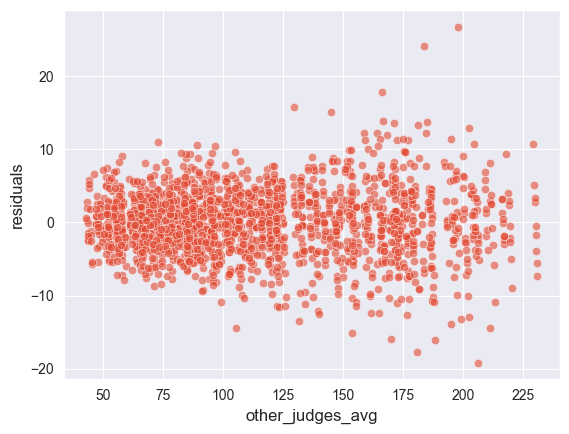

In [132]:
# predictor vs residuals
# testing: E[e | X] = 0 => expect dots to be centered around 0
# testing: Var(e | X) = sigma^2 => expect dots to be roughly same clustering from 0
sns.scatterplot(data=regression_df, x="other_judges_avg", y="residuals", alpha=0.6)
plt.show()

<Axes: xlabel='residuals', ylabel='Density'>

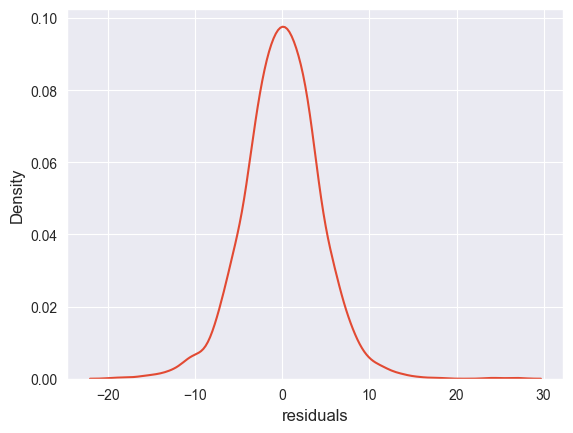

In [136]:
# distribution of residuals
sns.kdeplot(data=regression_df, x="residuals")

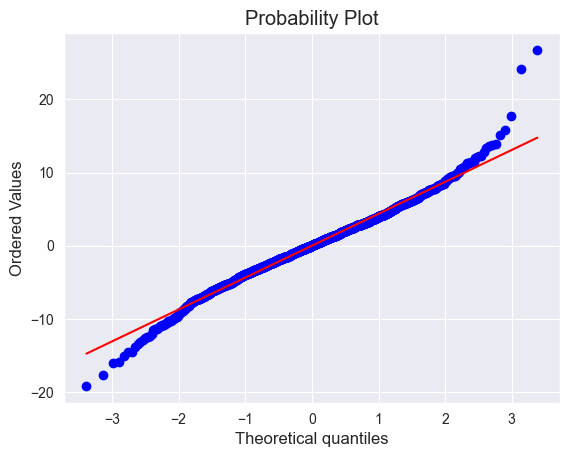

In [140]:
stats.probplot(regression_df["residuals"], dist='norm', plot=plt)
plt.show()

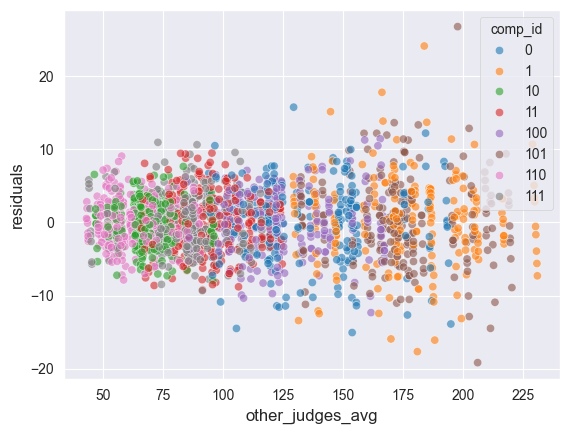

In [ ]:
# residuals independent of sample?
regression_df = regression_df.assign(comp_id = lambda x: x.is2018 * 100 + x.is_short_program * 10 + x.is_mens)
sns.scatterplot(data=regression_df, x="other_judges_avg", y="residuals", hue="comp_id", palette="tab10", alpha=0.6)
plt.show()

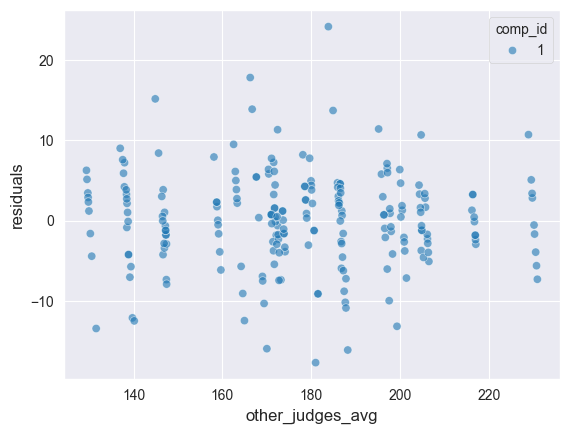

In [145]:
sns.scatterplot(data=regression_df[lambda x: x.comp_id == 1], x="other_judges_avg", y="residuals", hue="comp_id", palette="tab10", alpha=0.6)
plt.show()

# MISC

In [90]:
df = pd.DataFrame()
judge_cols = [f"J{i}" for i in range(1,10)]
for i in range(1,10):
    temp = pd.DataFrame()
    specific_judge_col = f"J{i}"
    specific_judge_nat = f"judge{i}_nat"
    specific_judge_same = f"judge{i}_same"
    temp["specific_judge"] = data_df[specific_judge_col]
    temp["specific_judge_nat"] = data_df[specific_judge_nat]
    temp["specific_judge_same"] = data_df[specific_judge_same]

    remaining_judges = [j for j in judge_cols if j != specific_judge_col]
    temp["other_judges_avg"] = data_df[remaining_judges].mean(axis=1)
    temp["is2018"] = (data_df["year"] == 2018).astype(int)
    temp["is_short_program"] = data_df["is_short_program"]
    temp["is_mens"] = data_df["is_mens"]
    temp["is_element"] = data_df["is_element"]



    df = pd.concat([df, temp])

In [91]:
df

specific_judge specific_judge_nat  specific_judge_same  \
0             2.0000                CAN                    0   
1             2.0000                CAN                    0   
2             2.0000                CAN                    0   
3             2.0000                CAN                    0   
4             3.0000                CAN                    0   
...              ...                ...                  ...   
3096          8.0000                CAN                    1   
3097          8.2500                CAN                    1   
3098          8.0000                CAN                    1   
3099          8.0000                CAN                    1   
3100          7.7500                CAN                    1   

      other_judges_avg  is2018  is_short_program  is_mens  is_element  
0               2.1250       1                 0        0           1  
1               2.3750       1                 0        0           1  
2               2.1250       1                 0        0           1  
3               2.8750       1                 0        0           1  
4               2.6250       1                 0        0           1  
...                ...     ...               ...      ...         ...  
3096            7.6250       0                 1        1           0  
3097            7.5938       0                 1        1           0  
3098            7.2812       0                 1        1           0  
3099            7.6875       0                 1        1           0  
3100            7.3438       0                 1        1           0  

[27909 rows x 8 columns]

In [29]:
df["specific_judge_same"].value_counts()

specific_judge_same
0    26471
1     1438
Name: count, dtype: int64

In [31]:
model = smf.ols(formula="specific_judge ~ other_judges_avg + specific_judge_same + is2018", data=df).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         specific_judge   R-squared:                       0.978
Model:                            OLS   Adj. R-squared:                  0.978
Method:                 Least Squares   F-statistic:                 4.055e+05
Date:                Wed, 04 Feb 2026   Prob (F-statistic):               0.00
Time:                        15:43:38   Log-Likelihood:                -22974.
No. Observations:               27909   AIC:                         4.596e+04
Df Residuals:                   27905   BIC:                         4.599e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept              -0.0019      0.006     -0.332      0.740      -0.013       0.009
other_judges_avg        0.9974      0.001   1100.381      0.000       0.996       0.999
specific_judge_same     0.2341      0.015     15.687      0.000       0.205       0.263
is2018                 -0.0024      0.007     -0.362      0.718      -0.015       0.011
==============================================================================
Omnibus:                     1138.473   Durbin-Watson:                   1.490
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             3482.141
Skew:                          -0.108   Prob(JB):                         0.00
Kurtosis:                       4.717   Cond. No.                         23.0
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

<Axes: xlabel='other_judges_avg', ylabel='specific_judge'>

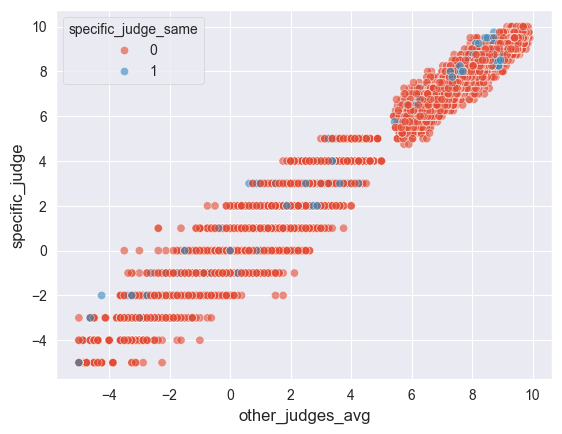

In [32]:
sns.scatterplot(df, x="other_judges_avg", y="specific_judge", hue="specific_judge_same", alpha=0.6)

In [37]:
# people complained about 2022 elena fomina FS
elena_df = df[lambda x: (x.is2018 == 0) & (x.is_mens == 0) & (x.is_short_program == 0) & (x.specific_judge_nat == "ROC")]
print(elena_df.shape)
elena_df.head()


(425, 7)


specific_judge specific_judge_nat  specific_judge_same  \
1560          2.0000                ROC                    1   
1561          4.0000                ROC                    1   
1562         -2.0000                ROC                    1   
1563          0.0000                ROC                    1   
1564          3.0000                ROC                    1   

      other_judges_avg  is2018  is_short_program  is_mens  
1560            2.0000       0                 0        0  
1561            3.0000       0                 0        0  
1562           -2.6250       0                 0        0  
1563           -1.5000       0                 0        0  
1564            2.6250       0                 0        0

In [38]:
model = smf.ols(formula="specific_judge ~ other_judges_avg + specific_judge_same", data=elena_df).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         specific_judge   R-squared:                       0.977
Model:                            OLS   Adj. R-squared:                  0.977
Method:                 Least Squares   F-statistic:                     8856.
Date:                Wed, 04 Feb 2026   Prob (F-statistic):               0.00
Time:                        15:44:08   Log-Likelihood:                -364.42
No. Observations:                 425   AIC:                             734.8
Df Residuals:                     422   BIC:                             747.0
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept              -0.0548      0.037     -1.493      0.136      -0.127       0.017
other_judges_avg        0.9794      0.007    131.848      0.000       0.965       0.994
specific_judge_same     0.5853      0.086      6.826      0.000       0.417       0.754
==============================================================================
Omnibus:                       21.527   Durbin-Watson:                   1.550
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               52.418
Skew:                          -0.188   Prob(JB):                     4.15e-12
Kurtosis:                       4.679   Cond. No.                         15.1
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [51]:
can_df = df[lambda x: (x.is2018 == 0) & (x.is_mens == 0) & (x.is_short_program == 0) & (x.specific_judge_nat == "CAN")]
print(can_df.shape)
can_df.head()


(425, 7)


specific_judge specific_judge_nat  specific_judge_same  \
1560          3.0000                CAN                    0   
1561          4.0000                CAN                    0   
1562         -3.0000                CAN                    0   
1563          0.0000                CAN                    0   
1564          2.0000                CAN                    0   

      other_judges_avg  is2018  is_short_program  is_mens  
1560            1.8750       0                 0        0  
1561            3.0000       0                 0        0  
1562           -2.5000       0                 0        0  
1563           -1.5000       0                 0        0  
1564            2.7500       0                 0        0

In [52]:
model = smf.ols(formula="specific_judge ~ other_judges_avg + specific_judge_same", data=can_df).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         specific_judge   R-squared:                       0.972
Model:                            OLS   Adj. R-squared:                  0.971
Method:                 Least Squares   F-statistic:                     7200.
Date:                Wed, 04 Feb 2026   Prob (F-statistic):               0.00
Time:                        15:46:17   Log-Likelihood:                -403.68
No. Observations:                 425   AIC:                             813.4
Df Residuals:                     422   BIC:                             825.5
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept               0.2971      0.040      7.503      0.000       0.219       0.375
other_judges_avg        0.9733      0.008    119.983      0.000       0.957       0.989
specific_judge_same     0.2886      0.155      1.856      0.064      -0.017       0.594
==============================================================================
Omnibus:                       31.037   Durbin-Watson:                   1.957
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              109.021
Skew:                           0.176   Prob(JB):                     2.12e-24
Kurtosis:                       5.456   Cond. No.                         24.8
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""